### Next Steps

- CHECK code avergaing and relate it to autocorrelation (double-check manually still necessary) 
- CHECK code second mode of collab 
- CHECK code two efficiency metrics 
- CHECK code random groups 
- CHECK best groups  
- CHECK code how to extract maximally diverse (C and HP)
- CHECK Broader: perform experiments  
    - ANOVA: https://www.pythonfordatascience.org/anova-python/ 
    - try to fix normality and unequal variance? --> consult with Ofer 
- dig through the results 

*Questions for Ofer*: 
- none of my assumptions are met for ANOVA (some for correlated landscapes)
- number of trials? 
- should I randomize which ones get picked to make the best groups?
- cannot get correlation coefficients for certain things when one of the two series is constant (1) because it is optimized according to that 
--> instead using all the ones for getting the score 

OFER: 
- assumptions are not that important 

## helper functions 
- create value function, create all heurisitcs, get all performances 

In [1]:
from itertools import permutations, combinations
import numpy as np

def create_value_func(distr_min=0, distr_max=100, length=2000, seed=None, correlated=False, sd=10, window=1, runs=10):
    """
    Creates a random value function uniformly distributed over inclusive interval from min to max of a given length 
    Returns np array
    If correlated=True, random Gaussian noise is added to previous value, based on passed standard deviation 
    Seed can be passed for reproducible results 
    Defaults are chosen according to Hong&Page 2004 
    """
    # the bigger the window the smoother
    #higher runs leads to more horizontal lines and everything gets dragged down ????

    if seed is not None:
        np.random.seed(seed)

    if correlated:

        func = np.random.randint(distr_min, distr_max+1, length) 
        # func = np.linspace(1,10,100)
        for i in range(runs):
            for i in range(len(func)):
                
                lower = i-window
                upper= i+window+1
                
                if lower<0:
                    slice1 = func[len(func)+lower:]
                    slice2 = func[:upper]
                    arr = np.concatenate((slice1, slice2))
                    
                elif upper>len(func):
                    slice1 = func[lower:]
                    slice2 = func[:upper-len(func)]
                    arr = np.concatenate((slice1, slice2))
                    
                else:
                    arr = func[lower:upper]

                func[i] = np.mean(arr)

        return func
            
        # second way of correlated functions:

        func = [np.random.randint(distr_min, distr_max)]
        noise = np.random.normal(0,sd,length-1)
        
        for i, val in enumerate(noise): 
            new = np.round(func[i]+val, 0)

            if new > 100 or new < 0:
                func = np.append(func, np.round(func[i]-val, 0))
            else: 
                func = np.append(func, new)

        return func

    else:
        return np.random.randint(distr_min, distr_max+1, 2000) # 


def create_all_heuristics(max_steps=12, size=3): 
    """ 
    Returns a list of all possible permuations (no repeating numbers) between 1 and max_steps (including) with each sublist having a given size 
    Defaults chosen according to Hong&Page 2004
    """

    return np.array(list(permutations(range(1,max_steps+1), size)))


def get_all_performances(max_steps=12, size=3, distr_min=0, distr_max=100, length=2000, seed=None, correlated=False, window=1, runs=10, all_heuristics=None, value_func=None):
    """
    returns a list of all OUTCOMES NOT PERFORMANCES, 
    can pass same arguuments as for value function and creating all heuristics  
    Alternatively, list of lists for all_heuristics is also possible 
    """
    
    if all_heuristics is None:
        all_heuristics = create_all_heuristics(max_steps=max_steps, size=size) 
    
    if value_func is None: 
        value_func = create_value_func(distr_min=distr_min, distr_max=distr_max, length=length, seed=seed, correlated=correlated, window=window, runs=runs) 
    
    return np.array([agent(heuristic_list=h).performance(value_func)[0] for h in all_heuristics])



## agents

In [2]:
class agent:
    """
    Agent class having an ID and a set of randomly generated heuristics 
    with max value 12 and a set size of 3 by default 
    Possible to pass a defined heuristic_list
    Otherwise a random heuristic set is defined based on len_heur and max_steps
    Optionally pass random seed for reproducible results    
    """

    # agent_id = 0

    def __init__(self,  len_heur=3, max_steps=12, heuristic_list=None, seed=None):
        if heuristic_list is not None :
            self.heuristics = np.array(heuristic_list)

        else: 
            self.heuristics = self.create_heuristics(len_heur, max_steps, seed)

        # self.id = self.agent_id
        # agent.agent_id+=1


    def create_heuristics(self, len_heur, max_steps, seed):
        rng = np.random.default_rng(seed)
        return np.round_(rng.choice(a=np.arange(max_steps)+1, size=len_heur, replace=False))

    def __repr__(self): 
        return f"Agent: {self.heuristics}"
    
    def __str__(self): 
        return f"Agent: {self.heuristics}"


    def apply_heur(self, value_func, starting_index, heuristic_index=0, not_moved=[], checks=0, moves=0): 
        """ 
        Class method 'apply_heur' for 'walking circle'/
        applying the set of heuristics to a given value_func until local optimum is reached by checking each heuristic one after another.
        Returns optimal value and corresping index in value_func. 
        """

        current_value = value_func[starting_index]

        if sum(not_moved) >= len(self.heuristics):
            return current_value, starting_index, checks, moves

        if heuristic_index == len(self.heuristics):
            heuristic_index -= len(self.heuristics)

        current_heur = self.heuristics[heuristic_index]

        current_index = starting_index + current_heur

        if current_index >= len(value_func)-1:
            current_index -= len(value_func)
            
        if current_value < value_func[current_index]:
            
            starting_index = current_index
            current_value = value_func[current_index]
            not_moved = []
            moves+=1
            
        else: 
            not_moved.append(True)

        heuristic_index += 1 # (this one should only happen if not moved otherwise it should be set to 0 again) - changed it for now but literature says it always goes to the next heursitic no matter what  
        # which one is true from the above 
        checks += 1
        return self.apply_heur(value_func, starting_index, heuristic_index, not_moved, moves=moves, checks=checks)
        
    
    def performance(self, value_func): 
        """ 
        Class method returns performance of an agent as expected value, expected checks and moves. 
        Uses average performance over all possible starting points in given value function as they are equally likely. 
        """

        sum_outcome = 0
        sum_checks = 0
        sum_moves = 0
        
        for i in range(len(value_func)): 
            p = self.apply_heur(value_func, starting_index=i, heuristic_index=0, not_moved=[], checks=0, moves=0)
            sum_outcome += p[0]
            sum_checks += p[2]
            sum_moves += p[3]

        return sum_outcome/len(value_func), sum_checks/len(value_func), sum_moves/len(value_func)
        


## Metrics 
- HP, group diversity and C diversity 

In [3]:
def diversity_score_HP(agent1, agent2):
    """
    Takes two agents and returns diversity as defined by hong and page (2004)
    Each element at each position of the heuristic is compared and differing values increase score, normalized by length of heuristic
    """

    diversity = 0

    for i, value in np.ndenumerate(agent2.heuristics): 
        if value != agent1.heuristics[i[0]]:
            diversity += 1

    return diversity/agent1.heuristics.shape[0]


                        
def group_diversity(group, scoring='HP'): 
    """
    Takes iterable of agents and returns average of diversity scores of all possible pairs according to a scoring function.
    """
    if scoring == 'HP': # they compare pairwise and average then 
        scores = [diversity_score_HP(pair[0], pair[1]) for pair in combinations(group, 2)] 

    return np.mean(scores)


def C_diversity(group, n_unique_max=12, adjusted=False):
    """
    Returns coverage diversity as defined by SINGER 
    Returns ratio of (heuristics covered by group)/(all possible heuristics)
    group: list of agents
    n_unique_max: number of unique heuristics 
    adjusted: If the group is too small to cover all heuristics it is adjusted such that maximally diverse groups have a score of 1 and adjusted is True.
    """

    full_set = np.array([])
    for a in group: 
        full_set = np.union1d(full_set, np.unique(a.heuristics))
    
    diversity = full_set.shape[0]/n_unique_max
    
    if adjusted == True and (group[0].heuristics.shape[0] * len(group)) < n_unique_max: 
        inverse_factor = n_unique_max/(group[0].heuristics.shape[0] * len(group))
    else: 
        inverse_factor = 1 


    return diversity*inverse_factor


## group composition 

In [4]:
def make_group(all_heuristics=None, value_func=None, size=10, agent_size=3, agent_max_steps=12, type='random', distr_min=0, distr_max=100, length=2000, seed=None, correlated=False, window=1, runs=10):
    '''
    Returns a list of heuristic lists of given size and their outcomes for 'random' heuristics, 'best' and maximally diverse (according to 'HP' and 'C' diversity)
    Diversity ones adds random list of heuristics to the group/randomly replaces exisiting ones until score is 1 (inefficient but guarantees non-deterministic group)
    Same arguments as for all_heuristics can be passed to create all heuristics, or all_heuristics list
    Same arguments as for get_all_performances can be passed to create value function 
    '''

    if all_heuristics is None:
        all_heuristics= create_all_heuristics(max_steps=agent_max_steps, size=agent_size)

    if value_func is None: # this allows me to pass value funcs to speed things up if I want to get multiple groups with same func, otherwise new one (with seed same) is always created on the fly 
        value_func=create_value_func(distr_min=distr_min, distr_max=distr_max, length=length, seed=seed, correlated=correlated, window=window, runs=runs)


    if type=='random': 
        rng = np.random.default_rng(seed=seed)
        heur = rng.choice(all_heuristics, size, replace=False)
        return heur#, get_all_performances(all_heuristics=heur, value_func=func)
        
    elif type=='best':  
        all_performances = get_all_performances(all_heuristics=all_heuristics, value_func=value_func)
        best_index = np.argsort(all_performances)[-size:]
        return all_heuristics[best_index]#, all_performances[best_index]

    elif type=='C': # usually at first go perfect score is reached with size 10 and max steps 12 
        rng = np.random.default_rng(seed=seed)
        heur = rng.choice(all_heuristics, size, replace=False)
        scoring_set= np.unique(heur)
        while True:

            if scoring_set.shape[0] == agent_max_steps: # add the n_unique parameters idea here instead of comparing shape
                return heur

            else:
                new_heur = rng.choice(all_heuristics, 1, replace=False)
                if new_heur not in heur:
                    heur[rng.integers(1, heur.shape[0])] = new_heur
                    scoring_set=np.unique(heur)

    elif type=='HP': 
        rng = np.random.default_rng(seed=seed)
        heur = rng.choice(all_heuristics, size, replace=False)
        
        while True:

            if group_diversity([agent(heuristic_list= h)for h in heur]) == 1: 
                return heur

            else:
                new_heur = rng.choice(all_heuristics, 1, replace=False)
                if new_heur not in heur:
                    heur[rng.integers(1, heur.shape[0])] = new_heur




## group performance 

In [5]:
def group_performance(group, value_func, sequential=True):
    """
    Takes a group of agents and returns performance (expected outcome, checks and moves)
    If sequential is true one agent performs as far as they get and next one takes up there 
    If sequential is false all agents perform for a given starting point and best result of them gets picked for inout as next round 
    """
    
    sum_outcome=0
    sum_checks = 0
    sum_moves = 0

    for i in range(len(value_func)):
        gp = group_performance_helper(group, value_func, i, sequential)
        sum_outcome += gp[0]
        sum_checks  += gp[1]
        sum_moves  += gp[2]

    return sum_outcome/len(value_func), sum_checks/len(value_func), sum_moves/len(value_func)
 


def group_performance_helper(group, value_func, endpoint, sequential):
    checks=0
    moves=0

    if sequential:
    
        while True:
            improved=False
            for agent in group:
                progress = agent.apply_heur(value_func, starting_index=endpoint, heuristic_index=0, not_moved=[])
                new = progress[1]
                checks+= progress[2]
                moves+= progress[3]

                if endpoint != new:
                    endpoint = new 
                    improved = True

            if improved==False: # this is not the perfect implmentation as you need a whole run from first agent to last to stop instead of from the one where you stopped improving &stop if you reach that one again
                return value_func[endpoint], checks, moves
         
    else: 
        while True:
            result= np.transpose([agent.apply_heur(value_func, starting_index=endpoint, heuristic_index=0, not_moved=[]) for agent in group])
            new = result[1][np.argmax(result[0])] # returns index of max val
            checks += sum(result[2])
            moves += sum(result[3])
            if endpoint == new: 
                return value_func[new], checks, moves
            else: 
                endpoint=new



## Experiments 

HP use 50 trials 
singer uses 1 mio and shows 50,000 representtive runs 

In [6]:
def get_all_performances2(max_steps=12, size=3, distr_min=0, distr_max=100, length=2000, seed=None, correlated=False, window=1, runs=10, all_heuristics=None, value_func=None):
    """
    A dict with key being the heuristics and value being the performance indicators , 
    can pass same arguuments as for value function and creating all heuristics  
    Alternatively, list of lists for all_heuristics is also possible 
    """
    
    if all_heuristics is None:
        all_heuristics = create_all_heuristics(max_steps=max_steps, size=size) 
    
    if value_func is None: 
        value_func = create_value_func(distr_min=distr_min, distr_max=distr_max, length=length, seed=seed, correlated=correlated, window=window, runs=runs) 
    
    return  {str(h): agent(heuristic_list=h).performance(value_func) for h in all_heuristics} 


In [ ]:
# # saving all performances of each agent on each landscape
# #  --> not necessary, has not been used further and only done for max_heur=12

# all_perf = []
# for i in range(50): # do it again with max heur being 20 because of c diversity - done 
#     print(i)
#     seed = i

#     func= create_value_func(seed=seed)
#     func_corr= create_value_func(seed=seed, correlated=True)

#     df1 = pd.DataFrame(get_all_performances2(value_func=func), index=['outcome', 'checks', 'moves'])
#     df1['func'] = i
#     all_perf.append(df1)

#     df2 = pd.DataFrame(get_all_performances2(value_func=func_corr), index=['outcome', 'checks', 'moves'])
#     all_perf.append(df2)
#     df2['func'] = i

# all_perf = pd.concat(all_perf) 
# all_perf.to_csv(r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\all_perf.csv')


In [ ]:
# getting results for max_steps = 20 
# import pandas as pd 

# df_performances_seq = pd.DataFrame(columns=['run', 'type',  'C_score', 'HP_score', 'outcome', 'checks', 'moves', 'outcome_corr', 'checks_corr', 'moves_corr', 'group'])
# df_performances = pd.DataFrame(columns=['run', 'type',  'C_score', 'HP_score', 'outcome', 'checks', 'moves', 'outcome_corr', 'checks_corr', 'moves_corr', 'group'])


# for i in range(50): # do it again with max heur being 20 because of c diversity - done 
#     print(i)
#     seed = i

#     func= create_value_func(seed=seed)
#     func_corr= create_value_func(seed=seed, correlated=True)

#     group_types = ('HP', 'C', 'random', 'best', 'best_corr')
#     groups = {}

#     for t in group_types: # probably need to randomize 
#         if t == 'best_corr': 
#             groups[t] = [agent(heuristic_list= h)for h in make_group(type='best', agent_max_steps=20, seed=seed, value_func=func_corr)]
#         else: 
#             groups[t] = [agent(heuristic_list= h)for h in make_group(type=t, agent_max_steps=20, seed=seed)] 


#     for g in groups.keys(): 
#         for b in (True, False): 
#             if g != 'best_corr':
#                 perf_seq = list(group_performance(group=groups[g], value_func=func, sequential=b))
#             else: 
#                 perf_seq = [np.nan for x in range(3)]

#             if g != 'best':
#                 perf_seq_corr = list(group_performance(group=groups[g], value_func=func_corr, sequential=b))
#             else: 
#                 perf_seq_corr= [np.nan for x in range(3)]

#             C_score = C_diversity(groups[g], n_unique_max=20)
#             HP_score = group_diversity(groups[g])

#             row = [i, g, C_score, HP_score]+perf_seq+perf_seq_corr+[[agent.heuristics for agent in groups[g]]]
#             df = pd.DataFrame([row], columns=['run', 'type', 'C_score', 'HP_score', 'outcome', 'checks', 'moves', 'outcome_corr', 'checks_corr', 'moves_corr', 'group'])
#             if b == True:
#                 df_performances_seq=pd.concat([df, df_performances_seq])
#             else:
#                 df_performances = pd.concat([df, df_performances])

# df_performances_seq.to_csv(r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv')
# # !cp df_performances_seq_20.csv '/content/drive/My Drive/Capstone - Diversity trumps ability/'

# df_performances.to_csv(r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv')
# # !cp df_performances_20.csv '/content/drive/My Drive/Capstone - Diversity trumps ability/'

In [ ]:
# # getting results for max_steps = 12

# import pandas as pd 

# df_performances_seq = pd.DataFrame(columns=['run', 'type',  'C_score', 'HP_score', 'outcome', 'checks', 'moves', 'outcome_corr', 'checks_corr', 'moves_corr', 'group'])
# df_performances = pd.DataFrame(columns=['run', 'type',  'C_score', 'HP_score', 'outcome', 'checks', 'moves', 'outcome_corr', 'checks_corr', 'moves_corr', 'group'])


# for i in range(50): # do it again with max heur being 20 because of c diversity - done 
#     print(i)
#     seed = i

#     func= create_value_func(seed=seed)
#     func_corr= create_value_func(seed=seed, correlated=True)

#     group_types = ('HP', 'C', 'random', 'best', 'best_corr')
#     groups = {}

#     for t in group_types: # probably need to randomize 
#         if t == 'best_corr': 
#             groups[t] = [agent(heuristic_list= h)for h in make_group(type='best', agent_max_steps=12, seed=seed, value_func=func_corr)]
#         else: 
#             groups[t] = [agent(heuristic_list= h)for h in make_group(type=t, agent_max_steps=12, seed=seed)] 


#     for g in groups.keys(): 
#         for b in (True, False): 
#             if g != 'best_corr':
#                 perf_seq = list(group_performance(group=groups[g], value_func=func, sequential=b))
#             else: 
#                 perf_seq = [np.nan for x in range(3)]

#             if g != 'best':
#                 perf_seq_corr = list(group_performance(group=groups[g], value_func=func_corr, sequential=b))
#             else: 
#                 perf_seq_corr= [np.nan for x in range(3)]

#             C_score = C_diversity(groups[g], n_unique_max=12)
#             HP_score = group_diversity(groups[g])

#             row = [i, g, C_score, HP_score]+perf_seq+perf_seq_corr+[[agent.heuristics for agent in groups[g]]]
#             df = pd.DataFrame([row], columns=['run', 'type', 'C_score', 'HP_score', 'outcome', 'checks', 'moves', 'outcome_corr', 'checks_corr', 'moves_corr', 'group'])
#             if b == True:
#                 df_performances_seq=pd.concat([df, df_performances_seq])
#             else:
#                 df_performances = pd.concat([df, df_performances])

# df_performances_seq.to_csv(r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv')
# # !cp df_performances_seq_20.csv '/content/drive/My Drive/Capstone - Diversity trumps ability/'

# df_performances.to_csv(r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv')
# # !cp df_performances_20.csv '/content/drive/My Drive/Capstone - Diversity trumps ability/'

In [5]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'
path3 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path4 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'

df_seq_12 = pd.read_csv(path1)
df_12 = pd.read_csv(path2)
df_seq_20 = pd.read_csv(path3)
df_20 = pd.read_csv(path4)

def extract_groups(df):
    """ 
    Function to turn groups column into array
    Takes df
    Returns pd.Series
    """

    out = pd.Series(name='groups', index=np.arange(0,len(df)), dtype=object)

    for index, g in enumerate(df['group']):
        heurs = [[]]
        skip = False  # dont think this is actually necessary, could also change inner try to setting skip 
        for i, l in enumerate(g): 
            if skip:
                skip = False 
            else:

                try:
                    h = int(l)

                    try: 
                        h2 = int(g[i+1])
                        h = int(l+str(h2))
                        skip = True
                    except: 
                        pass 

                    if len(heurs[-1])==3: 
                        heurs.append([h])
                    else: 
                        heurs[-1].append(h)
                except: 
                    pass 
        out.iloc[index] = heurs
    return out
        

def get_ind_perf(df_in):
    '''
    Function to retrospectively get the individual performances and save averages 
    '''
    df_out = pd.DataFrame(columns=['run', 'av_outcome', 'av_checks', 'av_moves', 'av_outcome_corr', 'av_checks_corr', 'av_moves_corr', 'all_perf'])
    for i in range(50): # do it again with max heur being 20 because of c diversity - done 
        print(i)
        seed = i
        df = df_in[df_in['run'] == i]
        
        func= create_value_func(seed=seed)
        func_corr= create_value_func(seed=seed, correlated=True)

        all_perf =[[(agent(heuristic_list=l).performance(func), agent(heuristic_list=l).performance(func_corr)) for l in g] for g in extract_groups(df)]
        all_means = [[(np.mean(indicator[0]), np.mean(indicator[1])) for indicator in np.transpose(group)] for group in all_perf]

        out = {'run': seed,
            'type': df['type'], 
            'av_outcome':[means[0][0] for means in all_means],
            'av_checks':[means[1][0] for means in all_means],
            'av_moves':[means[2][0] for means in all_means],
            'av_outcome_corr':[means[0][1] for means in all_means],
            'av_checks_corr':[means[1][1] for means in all_means],
            'av_moves_corr':[means[2][1] for means in all_means],
            'all_perf':[str(perf) for perf in all_perf]}

        out = pd.DataFrame(out)
        df_out = pd.concat([out, df_out])
    df_out['run'] = df_out['run'].astype('int64')
    return df_out
    

In [337]:
frames = {'df_20':df_20, 'df_seq_20':df_seq_20, 'df_12':df_12, 'df_seq_12':df_seq_12}

for f in frames: 
    out = get_ind_perf(frames[f])
    out.to_csv(fr'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\{f}_ind_perf.csv')
    complete = frames[f].merge(out, on= ['run', 'type'])
    complete.to_csv(r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\{f}_complete.csv')

### REGRESSION and assumptions 

In [3]:
def save_results(output, destination, gazer):
    """
    Helper to save the results of regressions either as .tex and/or as .html
    Takes the output file endings either as string or list, 
    the folder in which the file(s) are to be stored,
    and a stargazer instance"""

    
    file_name = input('Enter document name ')

    if 'html' in output:
        file_name += ".html" #Include directory path if needed
        f = open( file_name, "w" ) #This will overwrite an existing file
        f.write( gazer.render_html() )
        f.close()
        shutil.copy(file_name, destination)

    elif 'tex' in output:
        file_name += ".tex" #Include directory path if needed
        tex_file = open( file_name, "w" ) #This will overwrite an existing file
        tex_file.write(gazer.render_latex() )
        tex_file.close()
        shutil.copy(file_name, destination)



def check_assumption(y, x, model, y_label='Dependent Variable', x_label='Independent Variable'):
    """
    Helper to check regression assumptions 
    Shows probability plot & histogram of dependent var and residuals vs x-value
    Takes x and y (pandas series) as well as regression model (statsmodels.formula.api.ols) for the residuals 
    """

    # print('normality:', stats.shapiro(y))

    fig, axes = plt.subplots(1,3, figsize=(12,5))

    axes[0].hist(y, bins=20)
    axes[0].set_title('Histogram of performance indicator')

    stats.probplot(y, rvalue= True, plot=axes[1])
    axes[1].set_title("Probability plot of performance indicator")

    if x.dtype == 'object':
        sns.stripplot(x=x, y=model.resid, ax=axes[2])
    else: 
        axes[2].scatter(x=x, y=model.resid)
        
    axes[2].set_title('Residual Variance')
    axes[2].set(xlabel=x_label, ylabel='Residuals')

    fig.suptitle(f'Assumptions, indicator: {y_label}', fontsize=16)
    plt.tight_layout()
    # plt.show()
            


In [2]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd 
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import shutil 
import warnings
import seaborn as sns 


def get_results_regr(path_seq, path2, correlated=False, relative_eff=False, assumption=False, output=None, destination='/content/drive/My Drive/Capstone - Diversity trumps ability/Results/'):
    """
    Function to return results of the RQ1
    Takes paths to sequential and non-seq frame (csv files), 
    Booleans to decide whether to investigate the correlated landscapes,
    and use relative efficiency for number of checks and moves
    If output is passed files in tex and/or html format will be stored in folder destination (see save results)
    If assumption is set to true plots for residuals, histogram of the dependent var as well as probability plot are shown
    """ 
    
    warnings.filterwarnings('ignore')

    df_performances_seq = pd.read_csv(path_seq)
    df_performances = pd.read_csv(path2)
    dfs = {'sequential':df_performances_seq, 'non-sequential': df_performances}
    
    models = {}

    if correlated == False: 
        performance = ('outcome', 'checks', 'moves')
    else: 
        performance = ('outcome_corr', 'checks_corr', 'moves_corr')


    for indicator in performance:
        for df_name in dfs.keys():
            print(indicator)
            if correlated:
                df = dfs[df_name][dfs[df_name].type != 'best']
                best = "'best_corr'"                
            else: 
                df = dfs[df_name][dfs[df_name].type != 'best_corr']
                best = "'best'"

            if not indicator.startswith('outcome') and relative_eff:
                df[indicator] = df[performance[0]]/df[indicator]


            model = ols(indicator+f" ~ C(type, levels=({best}, 'random', 'HP', 'C'))", data= df).fit()
            models[indicator+', '+ df_name] = model
            
            if assumption:
                check_assumption(y=df[indicator], x=df['type'], model=model, y_label=indicator, x_label='Type of Group')
                

    gazer = Stargazer(models.values())
    gazer.custom_columns(list(models.keys()), list(map(int, np.ones(len(list(models.keys()))))))
    if correlated == False:
        gazer.rename_covariates({"C(type, levels=('best', 'random', 'HP', 'C'))[T.C]":'C', "C(type, levels=('best', 'random', 'HP', 'C'))[T.HP]":'HP', "C(type, levels=('best', 'random', 'HP', 'C'))[T.random]":'random', 'Intercept': 'Intercept (best)'})
    else:
        gazer.rename_covariates({"C(type, levels=('best_corr', 'random', 'HP', 'C'))[T.C]":'C', "C(type, levels=('best_corr', 'random', 'HP', 'C'))[T.HP]":'HP', "C(type, levels=('best_corr', 'random', 'HP', 'C'))[T.random]":'random', 'Intercept': 'Intercept (best)'})
    
    if output is not None:
        save_results(output=output, destination=destination, gazer=gazer)

        
    return HTML(gazer.render_html())

#### Uncorrelated value func

In [ ]:
# %pip install stargazer # for colab 

relative
outcome
outcome
checks
checks
moves
moves


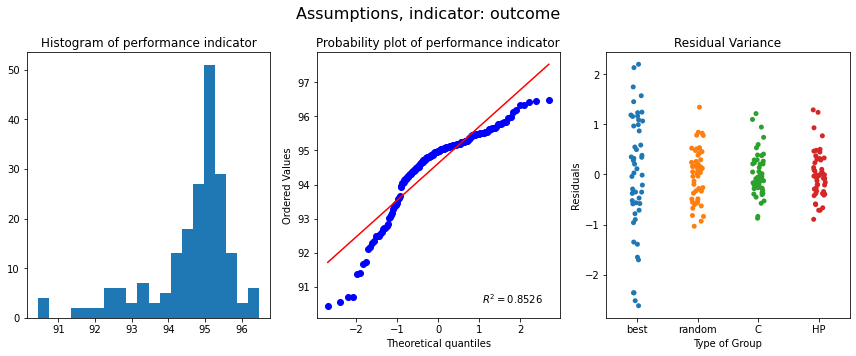

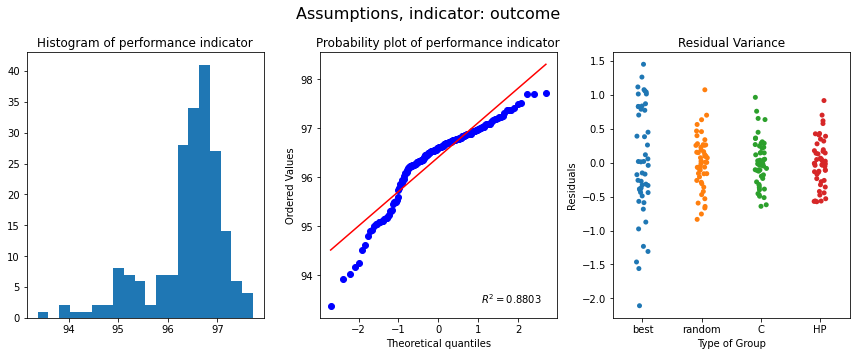

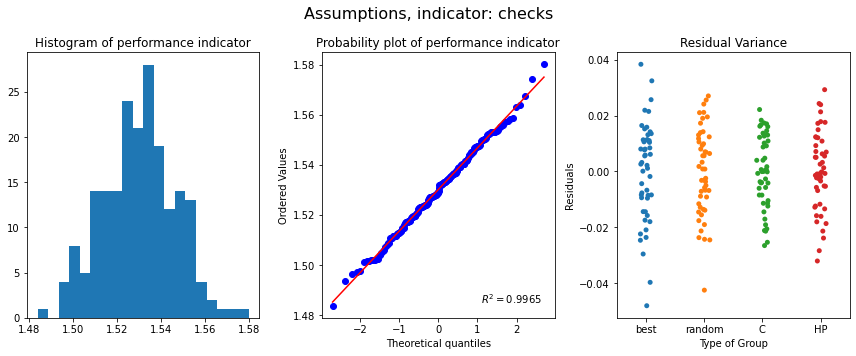

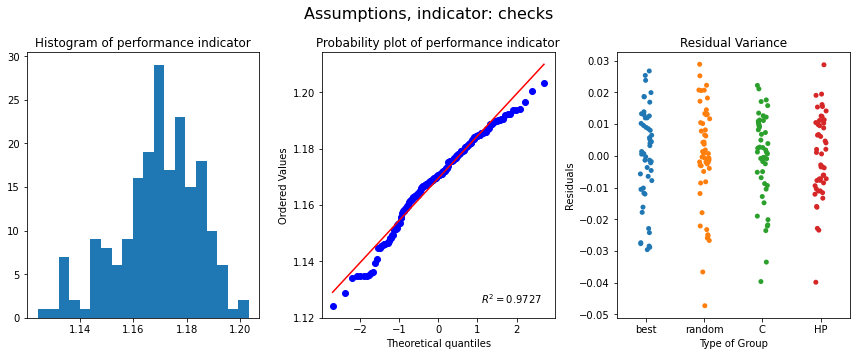

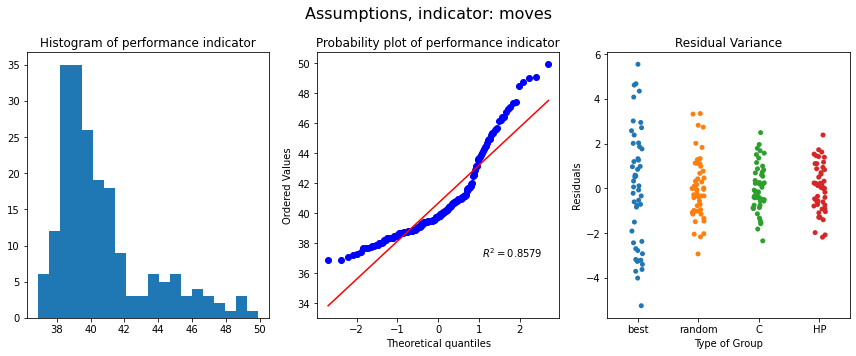

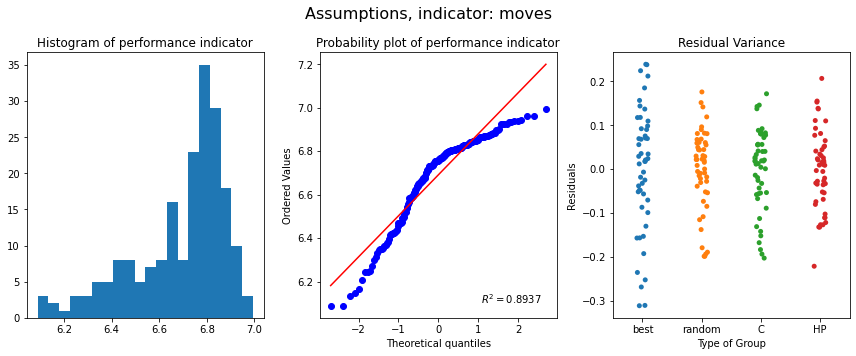

In [11]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'
dest= r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\tables_new'

print('relative')
get_results_regr(path1, path2, relative_eff=True, output='tex', assumption=True, destination=dest)

absolute
outcome
outcome
checks
checks
moves
moves


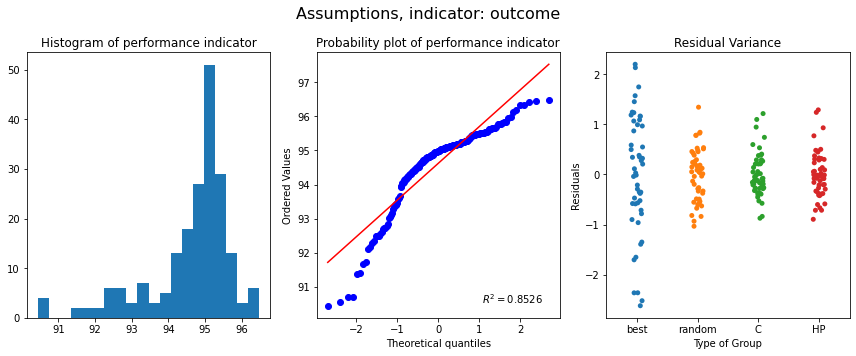

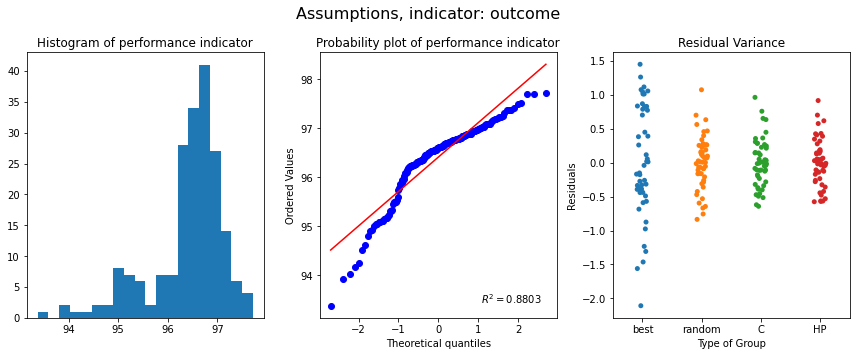

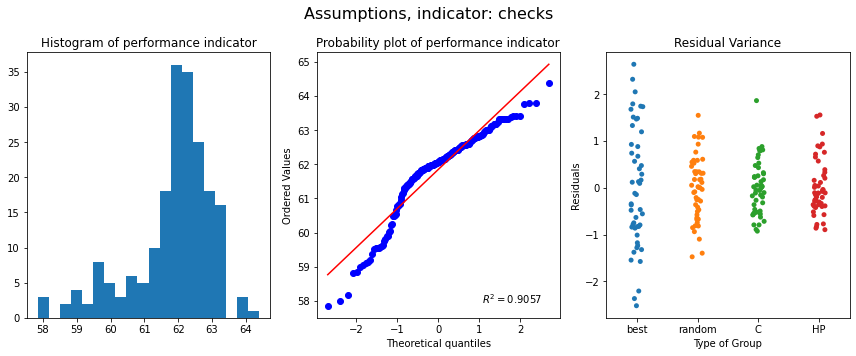

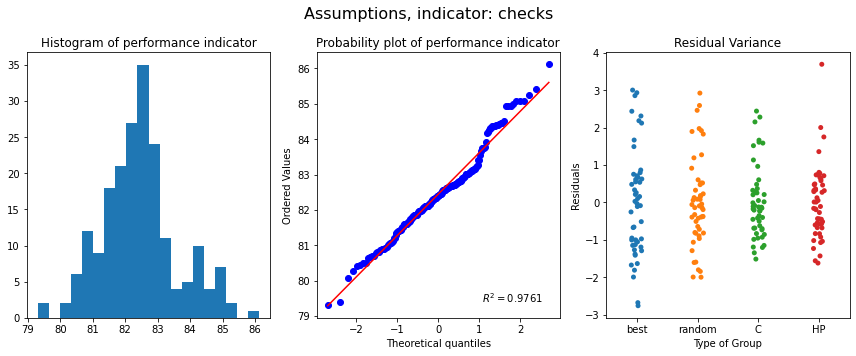

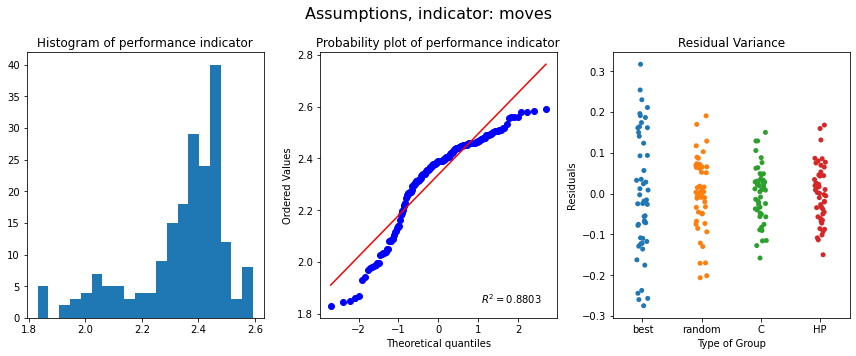

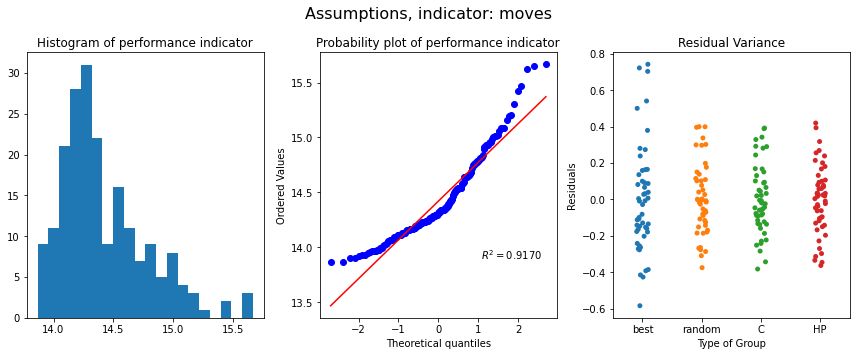

In [223]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'
dest= r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\tables'

print('absolute')
get_results_regr(path1, path2, relative_eff=False, output=None, assumption=True, destination=dest)

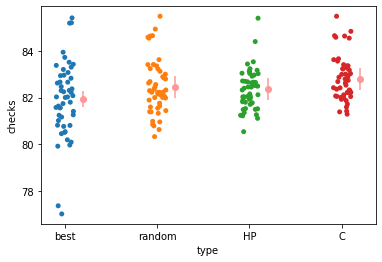

In [ ]:
import seaborn as sns
model = models['checks, non-sequential']
fig, ax = plt.subplots()
sns.stripplot(data=df_performances,x = df_performances['type'][df_performances['type']!='best_corr'],y = df_performances['checks'][df_performances['type']!='best_corr'],ax=ax, order=['best', 'random', 'HP', 'C'])
# params = [model.params[0], model.params[1], model.params[3], model.params[2]]
ncat = len(model.params[1:])
ax.scatter(x = np.arange(1)+0.2,y = model.params[0] , color = "#FE9898")
ax.scatter(x = np.arange(ncat)+1.2,y = model.params[1:]+model.params[0] , color = "#FE9898")
ax.vlines(x = np.arange(ncat)+1.2,
          ymin = model.conf_int().iloc[1:,0]+model.params[0],
          ymax = model.conf_int().iloc[1:,1]+model.params[0],
         color = "#FE9898")
ax.vlines(x = np.arange(1)+0.2,
          ymin = model.conf_int().iloc[0,0],
          ymax = model.conf_int().iloc[0,1],
         color = "#FE9898")

#### Correlated value func 

outcome_corr
outcome_corr
checks_corr
checks_corr
moves_corr
moves_corr


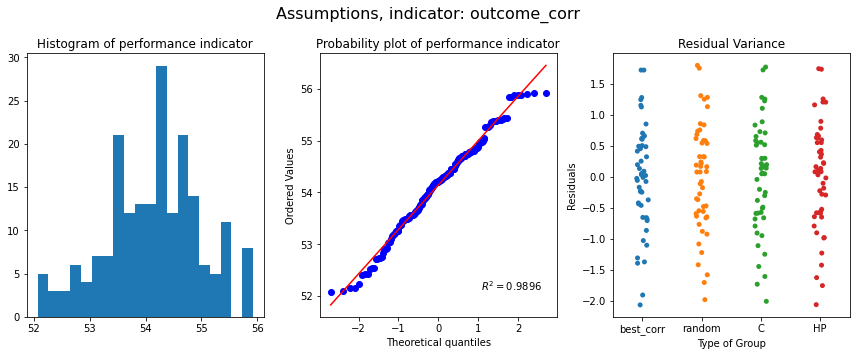

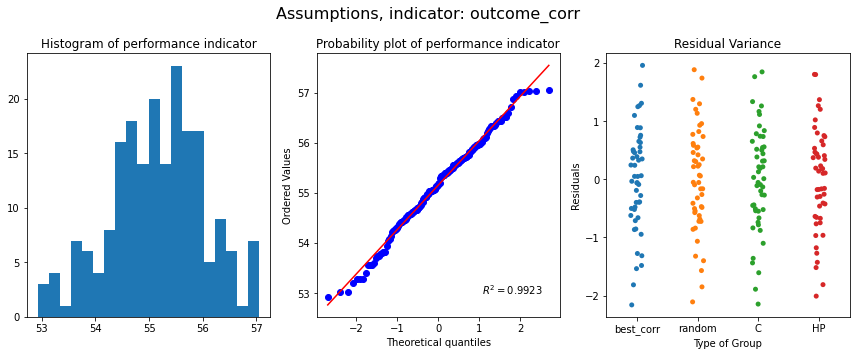

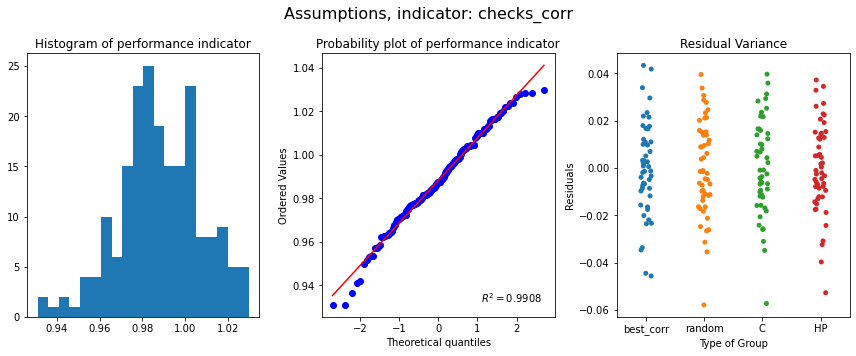

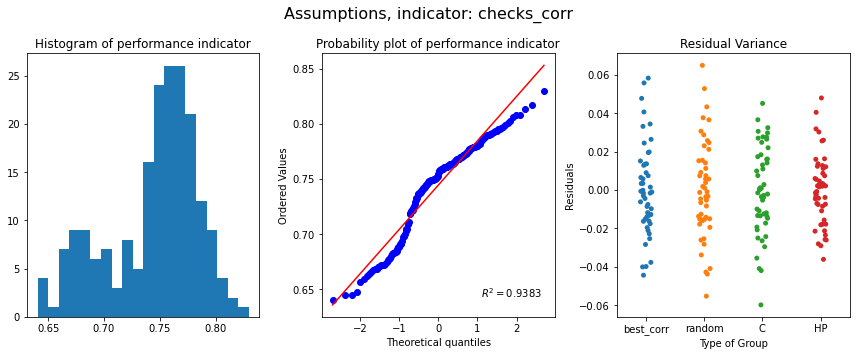

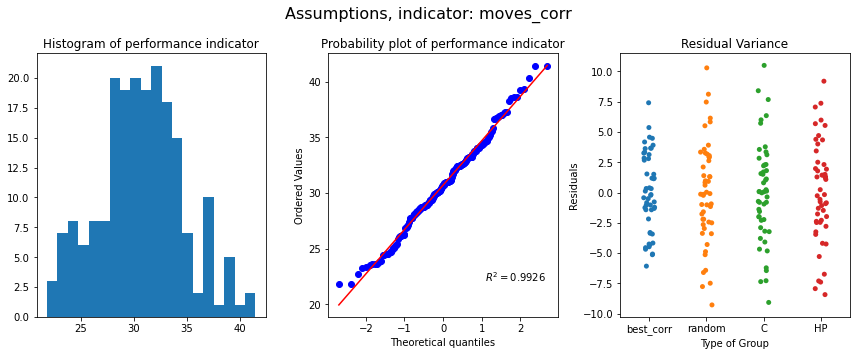

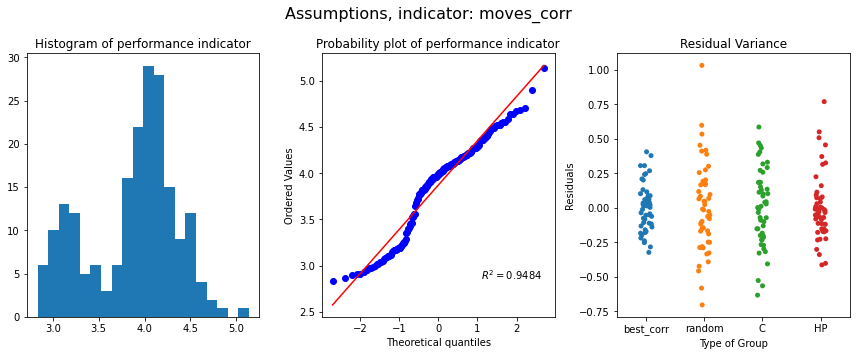

In [13]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'

get_results_regr(path1, path2, relative_eff=True, correlated=True, assumption=True, output='tex', destination=dest)

outcome_corr
outcome_corr
checks_corr
checks_corr
moves_corr
moves_corr


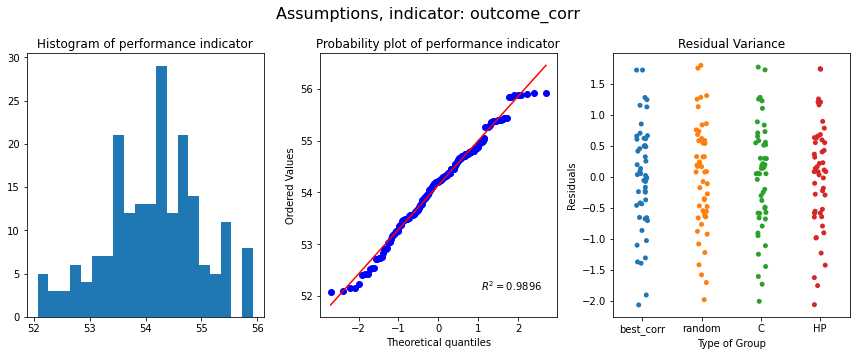

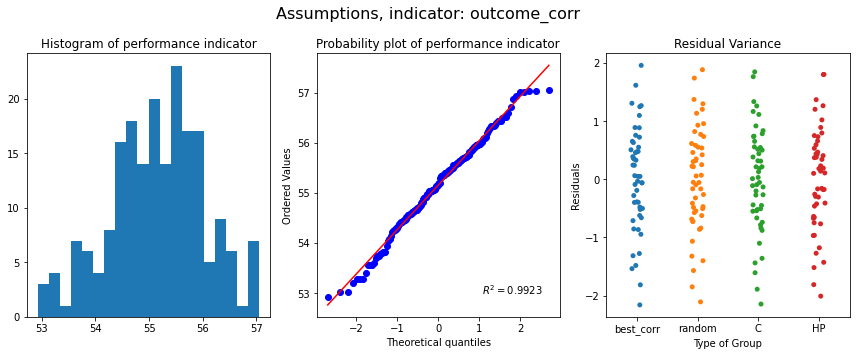

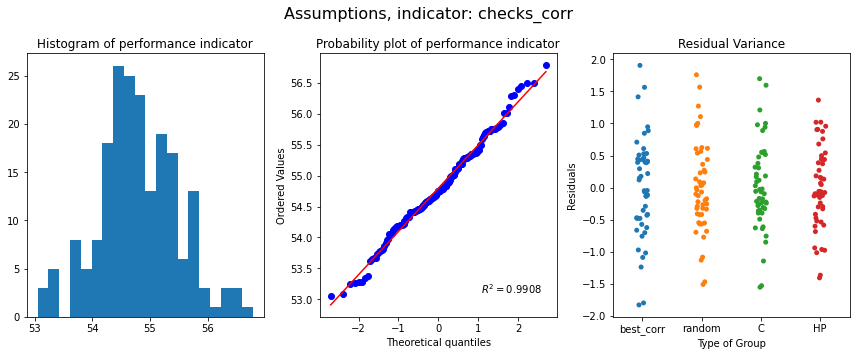

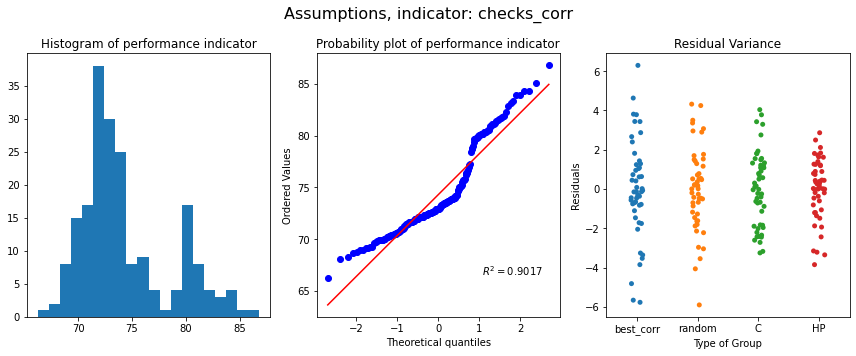

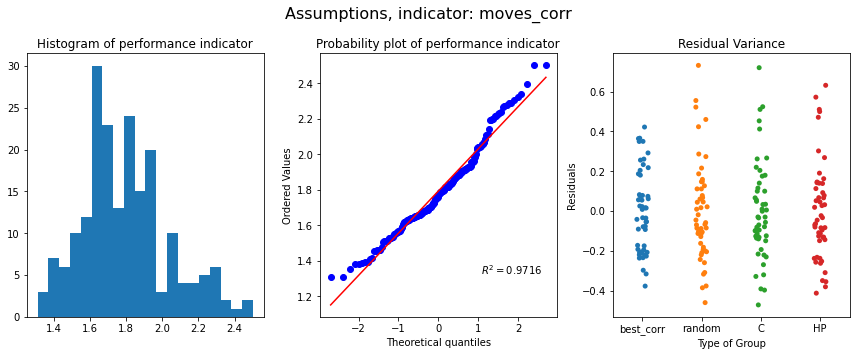

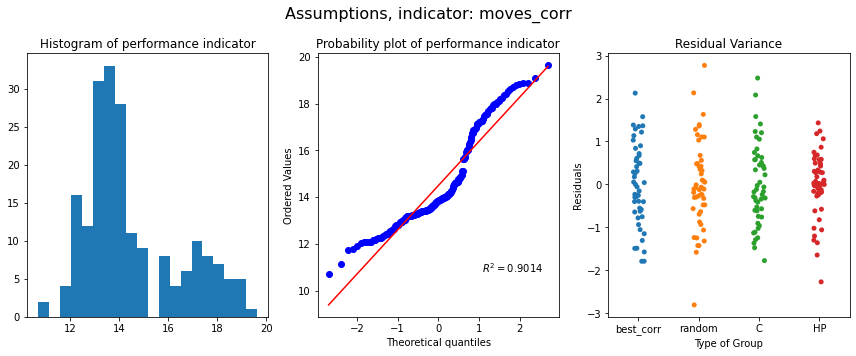

In [230]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'

get_results_regr(path1, path2, relative_eff=False, assumption=False, correlated=True, destination=dest, output=None)

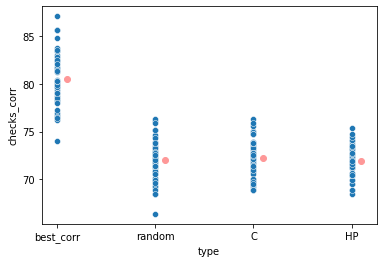

In [ ]:
import seaborn as sns
model = models['checks_corr, non-sequential']

fig, ax = plt.subplots()
sns.scatterplot(data=df_performances,x = df_performances['type'][df_performances['type']!='best'],y = df_performances['checks_corr'][df_performances['type']!='best'],ax=ax)
params = [model.params[0], model.params[1], model.params[3], model.params[2]]
ncat = len(params[1:])
ax.scatter(x = np.arange(1)+0.1,y = params[0] , color = "#FE9898")
ax.scatter(x = np.arange(ncat)+1.1,y = params[1:]+params[0] , color = "#FE9898")
# ax.vlines(x = np.arange(ncat)+1.1,
#           ymin = model.conf_int().iloc[:,0]+model.params[0],
#           ymax = model.conf_int().iloc[:,1]+model.params[0],
#          color = "#FE9898")

### Correlation Div

In [30]:
def get_results_corr(path_seq, path2, correlated=False, relative_eff=False, assumption=False, output=None, destination=None): 
    """
    Function to return results of the RQ2
        Shows plots with corr coeff and regression line (for illustrative purposes only) and regression table 
    Takes paths to sequential and non-seq frame (csv files), 
    Booleans to decide whether to investigate the correlated landscapes,
    and use relative efficiency for number of checks and moves
    If output is passed files in tex and/or html format will be stored in folder destination (see save results)
    """
    warnings.filterwarnings('ignore')
    
    df_performances_seq = pd.read_csv(path_seq)
    df_performances = pd.read_csv(path2)
    dfs = {'sequential':df_performances_seq, 'non-sequential': df_performances}
    
    fig_main, axes_main = plt.subplots(4,3, figsize=(15,15))
    y_plots=0

    if correlated == False: 
        performance = ('outcome', 'checks', 'moves')
    else: 
        performance = ('outcome_corr', 'checks_corr', 'moves_corr')
    
    performance_label = ('Group Outcome', 'Relative Number of Checks (Group)', 'Relative Number of Moves (Group)')

    models = {} 
    for x_plots, indicator in enumerate(performance):
        for score in ('C_score', 'HP_score'):
                for df_name in dfs.keys():
                    if correlated:
                        df = dfs[df_name][dfs[df_name].type != 'best']                                       
                    else: 
                        df = dfs[df_name][dfs[df_name].type != 'best_corr']
        
                    if y_plots%4 == 0:
                        y_plots=0

                    if not indicator.startswith('outcome') and relative_eff:
                        df[indicator] = df[performance[0]]/df[indicator]

                    sns.scatterplot(x=score, y=indicator, data=df, hue="type", ax=axes_main[y_plots, x_plots], alpha=0.7)

                    model = ols(indicator+" ~ "+score, data= df).fit()
                    models[indicator + ', '+ score + ', ' + df_name] = model

                    if assumption:
                        check_assumption(y=df[indicator], x=df[score], y_label=indicator, x_label=score, model=model)
        
                    m, b = np.polyfit(df[score], df[indicator], 1)

                    axes_main[y_plots, x_plots].plot(df[score], m*df[score]+b)
                    axes_main[y_plots, x_plots].set_title(label = df_name + ', correlation coeff.: ' + str(np.round(np.corrcoef(df[score], df[indicator])[0][1], decimals=2)))
                    axes_main[y_plots, x_plots].set(xlabel=f"Group Diversity Score ({score})", ylabel=performance_label[x_plots])
                    y_plots+=1

                    
    plt.tight_layout()
    plt.show()

    gazer = Stargazer(models.values())
    gazer.custom_columns(list(models.keys()), list(map(int, np.ones(len(list(models.keys()))))))

    if output is not None: 
        save_results(output=output, destination=destination, gazer=gazer)
            
    return HTML(gazer.render_html())
    

#### uncorr val func

In [20]:
df = pd.read_csv(r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv')
df[['C_score', 'HP_score']]

sum([1 if x < df['C_score'][i] else 0 for i, x in enumerate(df['HP_score'])])

np.mean([x - df['C_score'][i] for i, x in enumerate(df['HP_score'])])

0.21114814814814808

<AxesSubplot:xlabel='HP_score', ylabel='C_score'>

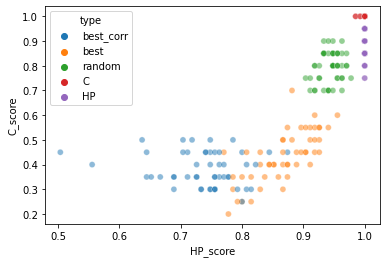

In [21]:
sns.scatterplot(x='HP_score', y='C_score', data=df, hue='type', alpha=0.5)

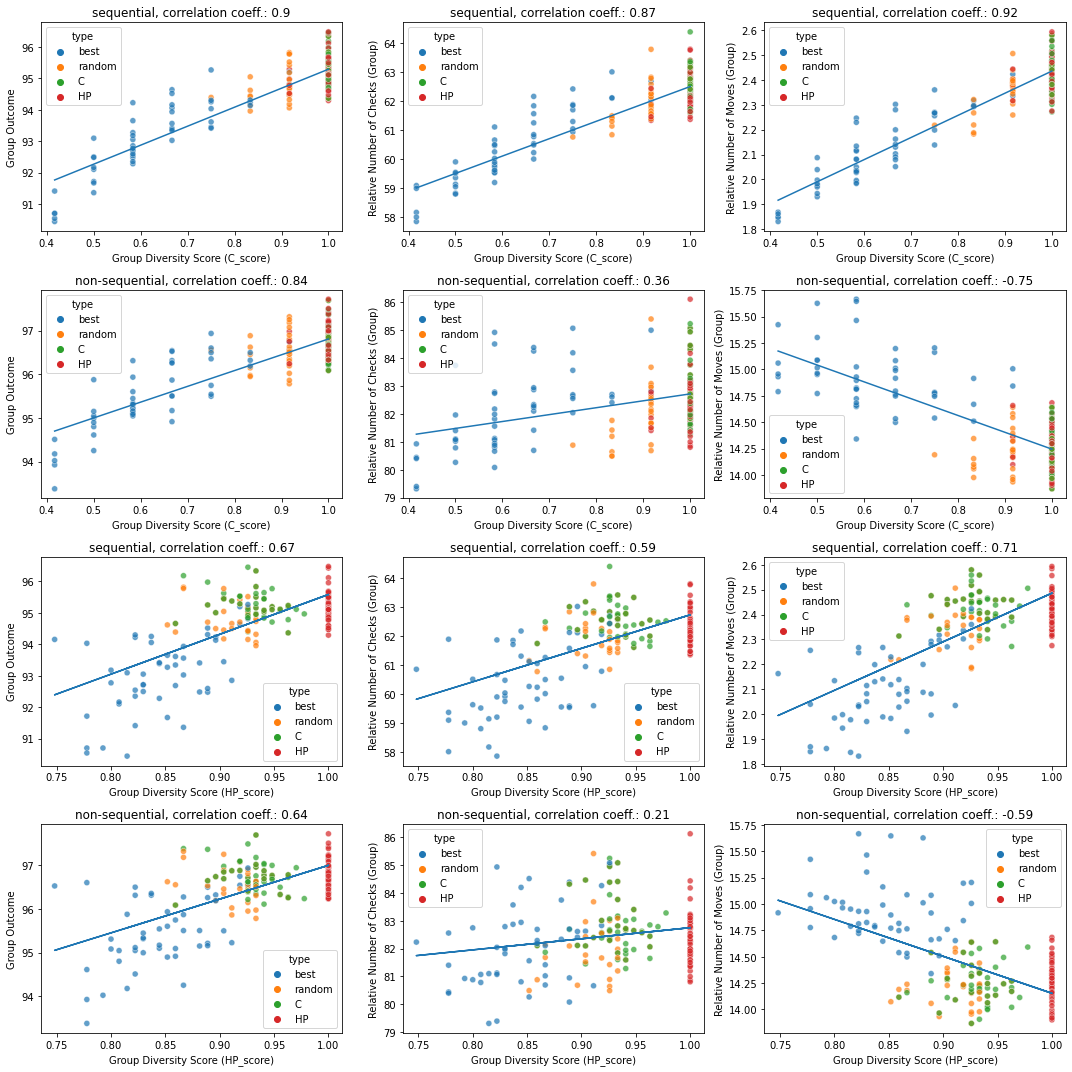

In [31]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'

dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=False, correlated=False, assumption=False, output=None, destination=dest)

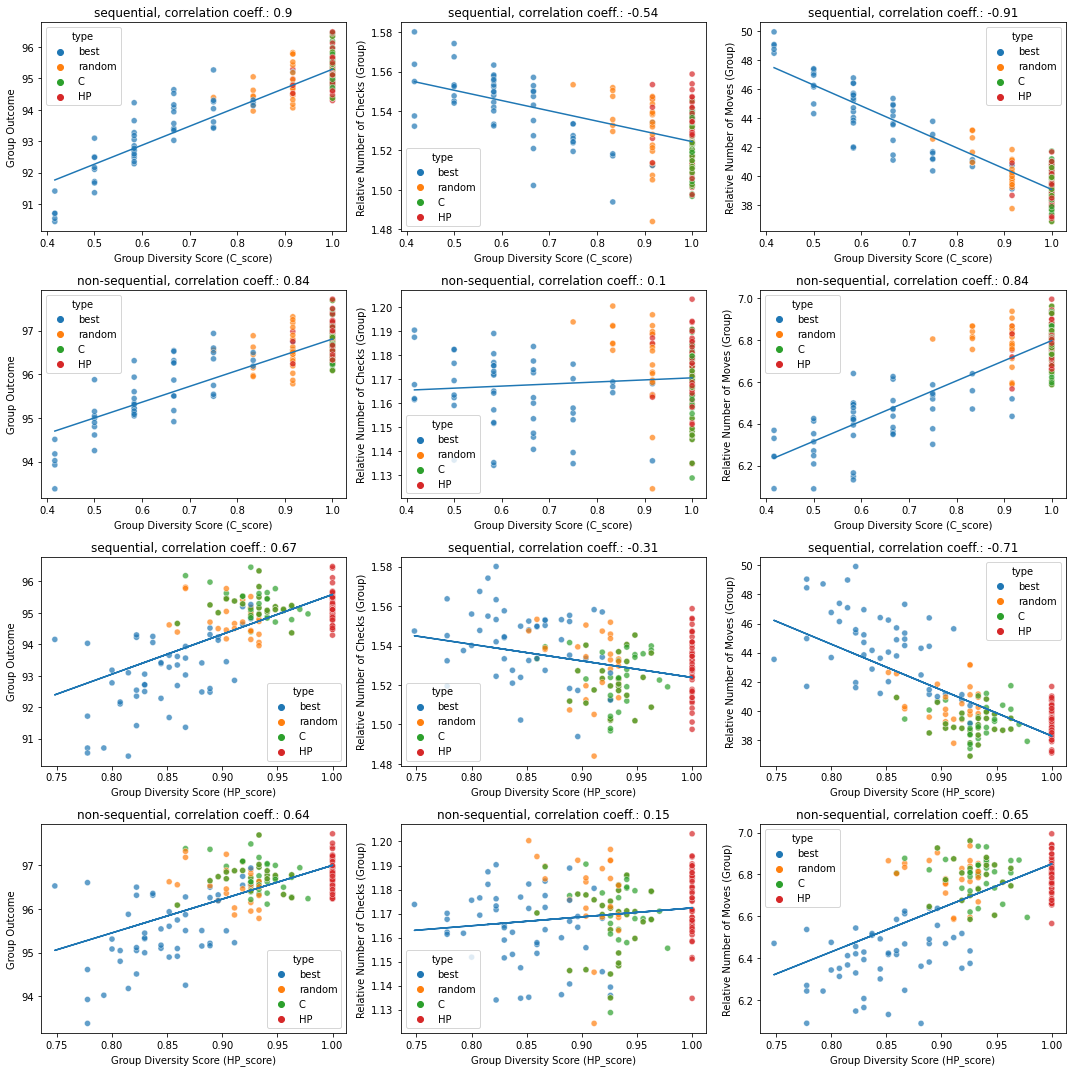

In [34]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'
dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=True, correlated=False, output=None, destination=dest)

#### corr val func 

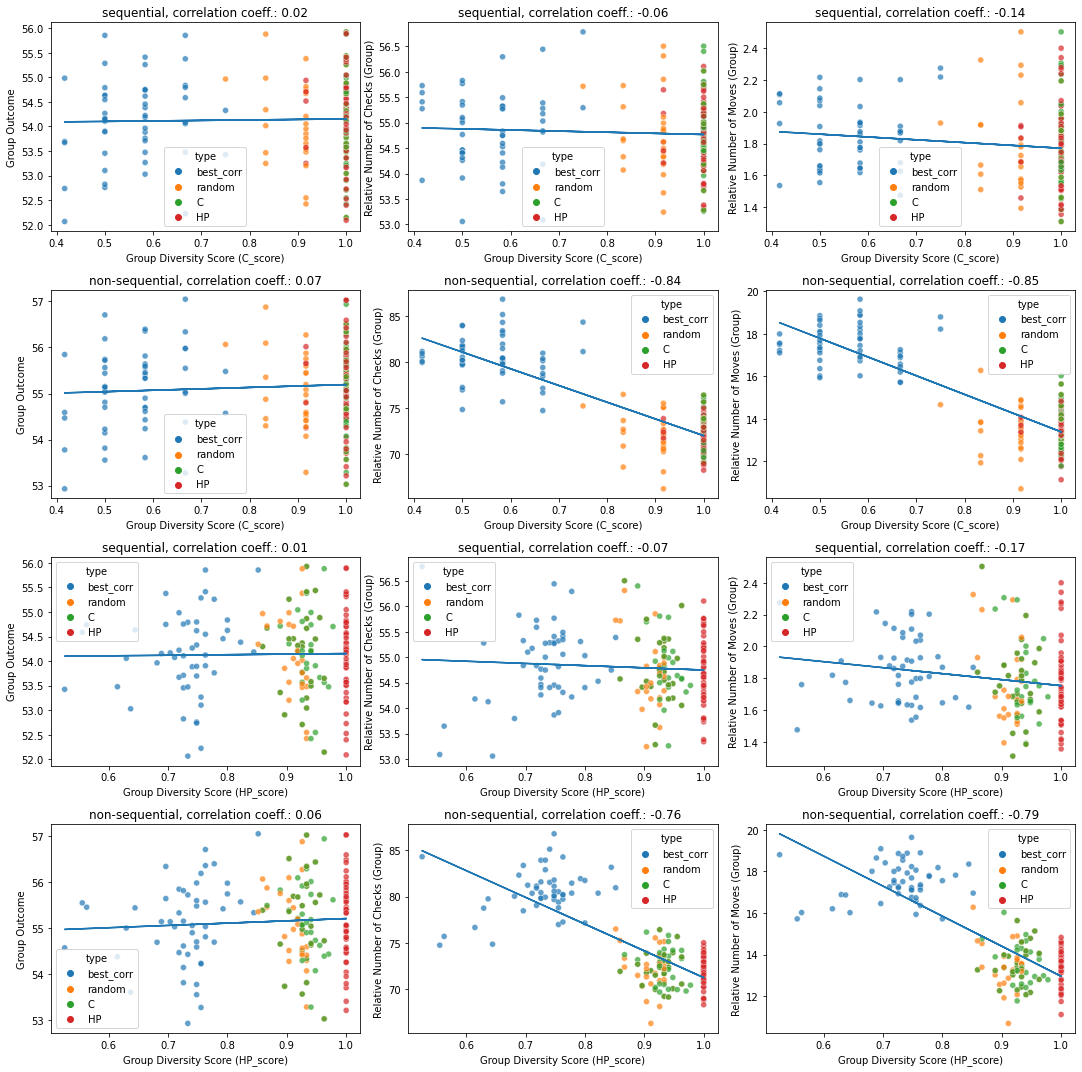

In [35]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'
dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=False, correlated=True, output=None, destination=dest)

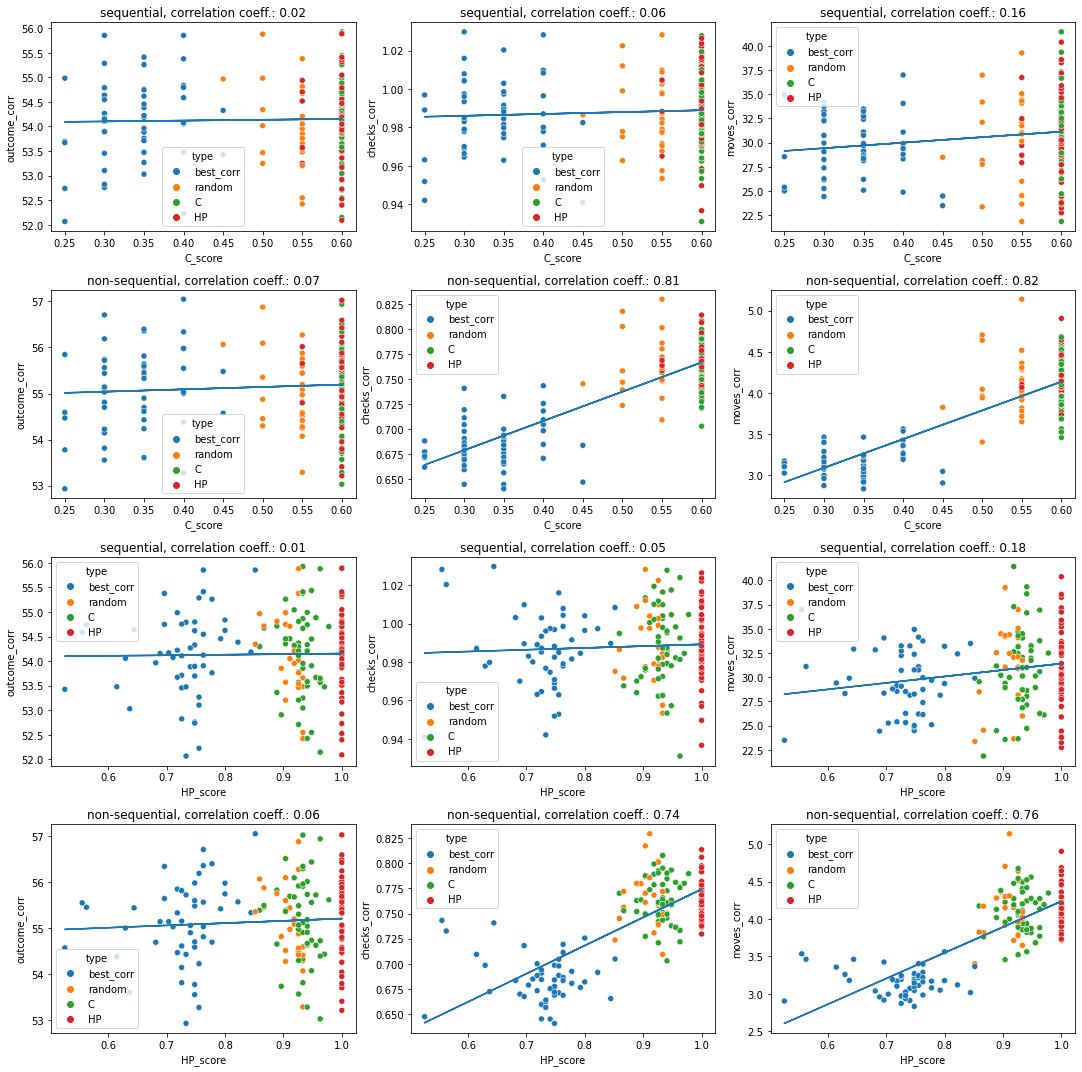

In [267]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new.csv'
dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=True, correlated=True, output=None, destination=dest)

In [24]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_12_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_12_complete.csv'

pd.read_csv(path2)

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  run       type   C_score  \
0             0             0               0   49  best_corr  0.500000   
1             1             1               0   49       best  0.416667   
2             2             2               0   49     random  1.000000   
3             3             3               0   49          C  1.000000   
4             4             4               0   49         HP  1.000000   
..          ...           ...             ...  ...        ...       ...   
245         245           245               0    0  best_corr  0.583333   
246         246           246               0    0       best  0.583333   
247         247           247               0    0     random  1.000000   
248         248           248               0    0          C  1.000000   
249         249           249               0    0         HP  1.000000   

     HP_score  outcome   checks    moves  ...  checks_corr  moves_corr  \
0    0.748148      NaN      NaN      NaN  ...      79.6815     16.7535   
1    0.814815  94.1770  79.3150  14.7895  ...          NaN         NaN   
2    0.925926  96.6030  84.3825  14.4190  ...      72.5325     13.2095   
3    0.925926  96.6030  84.3825  14.4190  ...      72.5325     13.2095   
4    1.000000  96.7905  83.2310  14.4315  ...      72.1340     13.1840   
..        ...      ...      ...      ...  ...          ...         ...   
245  0.748148      NaN      NaN      NaN  ...      86.8000     19.6335   
246  0.800000  95.0810  80.8820  14.6825  ...          NaN         NaN   
247  0.903704  96.8440  84.4600  14.2945  ...      73.8685     13.9870   
248  0.903704  96.8440  84.4600  14.2945  ...      73.8685     13.9870   
249  1.000000  96.9945  83.0980  14.2975  ...      72.9310     13.4145   

                                                 group av_outcome  av_checks  \
0    [array([ 7,  2, 12]), array([ 2,  6, 12]), arr...   83.90765    5.21630   
1    [array([ 7, 12,  9]), array([ 9, 12,  7]), arr...   85.41285    5.28555   
2    [array([11,  2, 10]), array([8, 6, 3]), array(...   84.44200    5.21600   
3    [array([11,  2, 10]), array([8, 6, 3]), array(...   84.44200    5.21600   
4    [array([11,  2, 10]), array([10, 12,  4]), arr...   84.34395    5.21450   
..                                                 ...        ...        ...   
245  [array([ 8, 12,  2]), array([ 2,  6, 12]), arr...   85.93950    5.21665   
246  [array([9, 7, 4]), array([9, 4, 2]), array([4,...   86.81410    5.27200   
247  [array([11,  2,  7]), array([10,  9,  4]), arr...   85.84525    5.19845   
248  [array([11,  2,  7]), array([10,  9,  4]), arr...   85.84525    5.19845   
249  [array([11,  2,  7]), array([2, 1, 8]), array(...   85.82500    5.20355   

     av_moves  av_outcome_corr  av_checks_corr  av_moves_corr  \
0     1.41210         52.58065         5.73495        1.67175   
1     1.46330         51.81360         4.58375        1.13875   
2     1.41090         51.25805         4.93570        1.30520   
3     1.41090         51.25805         4.93570        1.30520   
4     1.41280         51.04235         4.84790        1.29820   
..        ...              ...             ...            ...   
245   1.41865         54.34210         6.41040        1.95770   
246   1.44705         52.94980         4.62865        1.18425   
247   1.39835         52.39970         5.00285        1.38280   
248   1.39835         52.39970         5.00285        1.38280   
249   1.40905         52.88845         4.83890        1.32095   

                                              all_perf  
0    [((84.4135, 5.2085, 1.419), (52.563, 5.3515, 1...  
1    [((85.3795, 5.278, 1.459), (51.5105, 4.4385, 1...  
2    [((84.0565, 5.086, 1.345), (51.936, 5.183, 1.3...  
3    [((84.0565, 5.086, 1.345), (51.936, 5.183, 1.3...  
4    [((84.0565, 5.086, 1.345), (51.936, 5.183, 1.3...  
..                                                 ...  
245  [((86.205, 5.195, 1.416), (54.3155, 5.632, 1.5...  
246  [((86.769, 5

['random' 'C' 'HP']


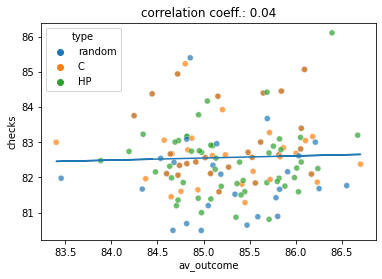

In [69]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_12_complete.csv'
df = pd.read_csv(path1)
df = df[(df['type'] != 'best') & (df['type'] != 'best_corr')]

print(df['type'].unique())
ax = plt.subplot(111)

sns.scatterplot(x='av_outcome', y='checks', data=df, hue="type", alpha=0.7)
m, b = np.polyfit(df['av_outcome'], df['checks'], 1)

ax.plot(df['av_outcome'], m*df['av_outcome']+b)
ax.set_title(label = 'correlation coeff.: ' + str(np.round(np.corrcoef(df['av_outcome'], df['checks'])[0][1], decimals=2)))
# ax.set(xlabel=ability, ylabel=indicator)
plt.show()

In [36]:
def get_results_corr_ab(path_seq, path2, correlated=False, relative_eff=False, assumption=False, output=None, destination=None): 
    """
    Function to return results of the RQ2
        Shows plots with corr coeff and regression line (for illustrative purposes only) and regression table 
    Takes paths to sequential and non-seq frame (csv files), 
    Booleans to decide whether to investigate the correlated landscapes,
    and use relative efficiency for number of checks and moves
    If output is passed files in tex and/or html format will be stored in folder destination (see save results)
    """
    warnings.filterwarnings('ignore')
    
    df_performances_seq = pd.read_csv(path_seq)
    df_performances = pd.read_csv(path2)
    dfs = {'sequential':df_performances_seq, 'non-sequential': df_performances}
    
    fig_main, axes_main = plt.subplots(2,3, figsize=(15,7.5))
    y_plots=0

    if correlated == False: 
        performance = ('outcome', 'checks', 'moves')
        ability = 'av_outcome'
        # dfs['sequential'] = dfs['sequential'][df['type'] != 'best_corr']
        # dfs['non-sequential'] = dfs['non-sequential'][df['type'] != 'best_corr']
    else: 
        performance = ('outcome_corr', 'checks_corr', 'moves_corr')
        ability = 'av_outcome_corr'
        # dfs['sequential'] = dfs['sequential'][df['type'] != 'best']
        # dfs['non-sequential'] = dfs['non-sequential'][df['type'] != 'best']
    performance_label = ('Group Outcome', 'Relative Number of Checks (Group)', 'Relative Number of Moves (Group)')

    models = {} 
    for x_plots, indicator in enumerate(performance):
        for y_plots, df_name in enumerate(dfs.keys()):
            if correlated:
                df = dfs[df_name][dfs[df_name].type != 'best']                                       
            else: 
                df = dfs[df_name][dfs[df_name].type != 'best_corr']

            if not indicator.startswith('outcome') and relative_eff:
                df[indicator] = df[performance[0]]/df[indicator]

            sns.scatterplot(x=ability, y=indicator, data=df, hue="type", ax=axes_main[y_plots, x_plots], alpha=0.7)

            model = ols(indicator+" ~ "+ability, data= df).fit()
            models[indicator + ', '+ ability + ', ' + df_name] = model

            if assumption:
                check_assumption(y=df[indicator], x=df[ability], y_label=indicator, x_label=ability, model=model)

            m, b = np.polyfit(df[ability], df[indicator], 1)

            axes_main[y_plots, x_plots].plot(df[ability], m*df[ability]+b)
            axes_main[y_plots, x_plots].set_title(label = df_name + ', correlation coeff.: ' + str(np.round(np.corrcoef(df[ability], df[indicator])[0][1], decimals=2)))
            axes_main[y_plots, x_plots].set(xlabel='Average Individual Ability (Outcome)', ylabel=performance_label[x_plots])

                    
    plt.tight_layout()
    plt.show()

    gazer = Stargazer(models.values())
    gazer.custom_columns(list(models.keys()), list(map(int, np.ones(len(list(models.keys()))))))

    if output is not None: 
        save_results(output=output, destination=destination, gazer=gazer)
            
    return HTML(gazer.render_html())
    

### Correlation Ability 

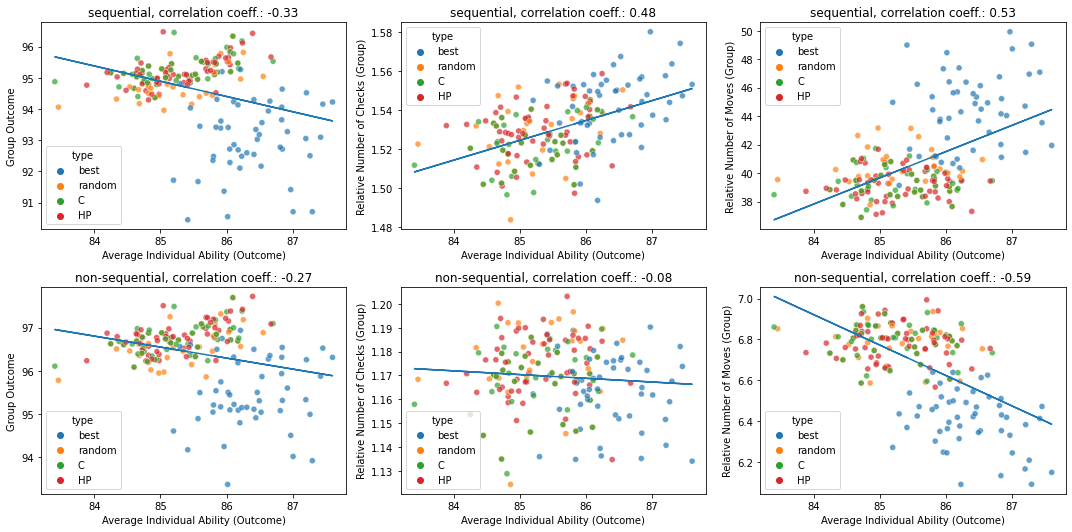

In [37]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_12_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_12_complete.csv'

get_results_corr_ab(path1, path2, relative_eff=True)

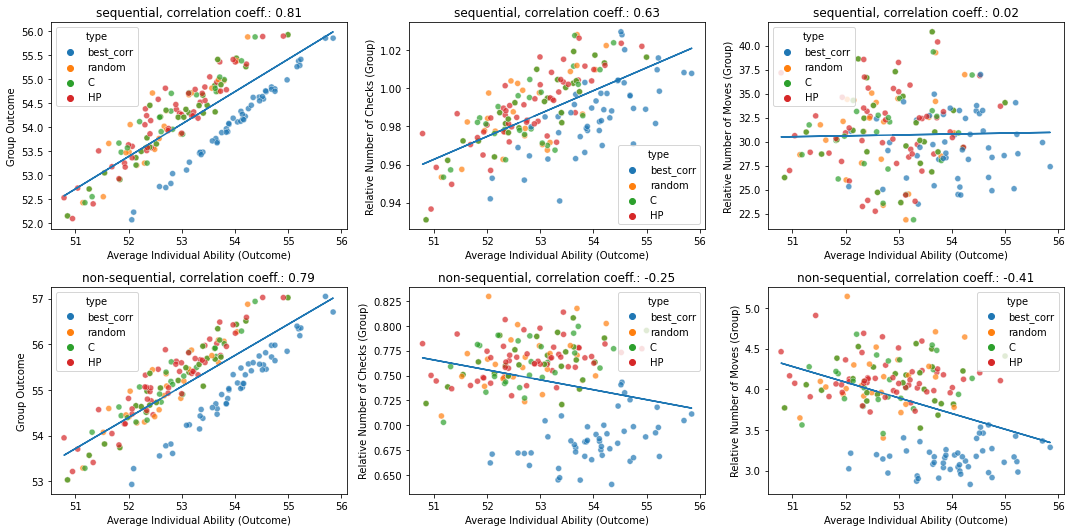

In [38]:
get_results_corr_ab(path1, path2, relative_eff=True, correlated=True)

### Ability & Diversity

In [40]:
from sklearn.preprocessing import MinMaxScaler

def get_results_ab_div(path_seq, path2, correlated=False, relative_eff=False, assumption=False, output=None, destination=None): 
    """
    Function to return results of the RQ2
        Shows plots with corr coeff and regression line (for illustrative purposes only) and regression table 
    Takes paths to sequential and non-seq frame (csv files), 
    Booleans to decide whether to investigate the correlated landscapes,
    and use relative efficiency for number of checks and moves
    If output is passed files in tex and/or html format will be stored in folder destination (see save results)
    """
    warnings.filterwarnings('ignore')
    
    df_performances_seq = pd.read_csv(path_seq)
    df_performances = pd.read_csv(path2)
    dfs = {'sequential':df_performances_seq, 'non-sequential': df_performances}
    
    fig_main, axes_main = plt.subplots(4,3, figsize=(15,15))
    y_plots=0
    models = dict()

    if correlated == False: 
        performance = ('outcome', 'checks', 'moves')
        ability = 'av_outcome'
    else: 
        performance = ('outcome_corr', 'checks_corr', 'moves_corr')
        ability = 'av_outcome_corr'

    performance_label = ('Average Group Outcome', 'Average Relative Number of Checks (Group)', 'Average Relative Number of Moves (Group)')

    for x_plots, indicator in enumerate(performance):
        for score in ('C_score', 'HP_score'):
                for df_name in dfs.keys():
                    if correlated:
                        df = dfs[df_name][dfs[df_name].type != 'best']                                       
                    else: 
                        df = dfs[df_name][dfs[df_name].type != 'best_corr']
        
                    if y_plots%4 == 0:
                        y_plots=0

                    if not indicator.startswith('outcome') and relative_eff:
                        df[indicator] = df[performance[0]]/df[indicator]

                    if correlated: 
                        h1 = axes_main[y_plots, x_plots].hexbin(x=df[score], y=df[ability], C=df[indicator], gridsize=15, cmap='summer')
                    else:
                        h1 = axes_main[y_plots, x_plots].hexbin(x=df[score], y=df[ability], C=df[indicator], gridsize=15, cmap='summer')

                    # this would be it if I wanted it to do wiht ind indicator = group one, instead more interesting to do outcome   
                    # if correlated: 
                    #     h1 = axes_main[y_plots, x_plots].hexbin(x=df[score], y=df[f"av_{indicator[:-5]}"], C=df[indicator], gridsize=15, cmap='summer')
                    # else:
                    #     h1 = axes_main[y_plots, x_plots].hexbin(x=df[score], y=df[f"av_{indicator}"], C=df[indicator], gridsize=15, cmap='summer')
                    cb = fig_main.colorbar(h1, ax=axes_main[y_plots, x_plots])
                    cb.set_label(performance_label[x_plots])

                    axes_main[y_plots, x_plots].set(title=f"Deliberation mode: {df_name}", ylabel=f'Average individual ability (outcome)', xlabel=f'Group Diversity Score ({score})')

                    y_plots+=1

                    scaler= MinMaxScaler()
                    df[[indicator+'regr', ability+'regr']] = scaler.fit_transform(df[[indicator, ability]])
            
                    model = ols(indicator+'regr'+" ~ "+ability+'regr' + ' + ' + score, data= df).fit()
                    models[f'{indicator}, {ability}, {df_name}, {score}'] = model

                    if assumption:
                        check_assumption(y=df[indicator], x=df[ability], y_label=indicator, x_label=ability, model=model)
                    
    plt.tight_layout()
    plt.show()

    gazer = Stargazer(models.values())
    gazer.custom_columns(list(models.keys()), list(map(int, np.ones(len(list(models.keys()))))))
    if not correlated:
        gazer.rename_covariates({'av_outcomeregr': 'Average Individual Ability'})
    else: 
        gazer.rename_covariates({'av_outcome_corrregr': 'Average Individual Ability'})

    if output is not None: 
        save_results(output=output, destination=destination, gazer=gazer)
            
    return HTML(gazer.render_html())


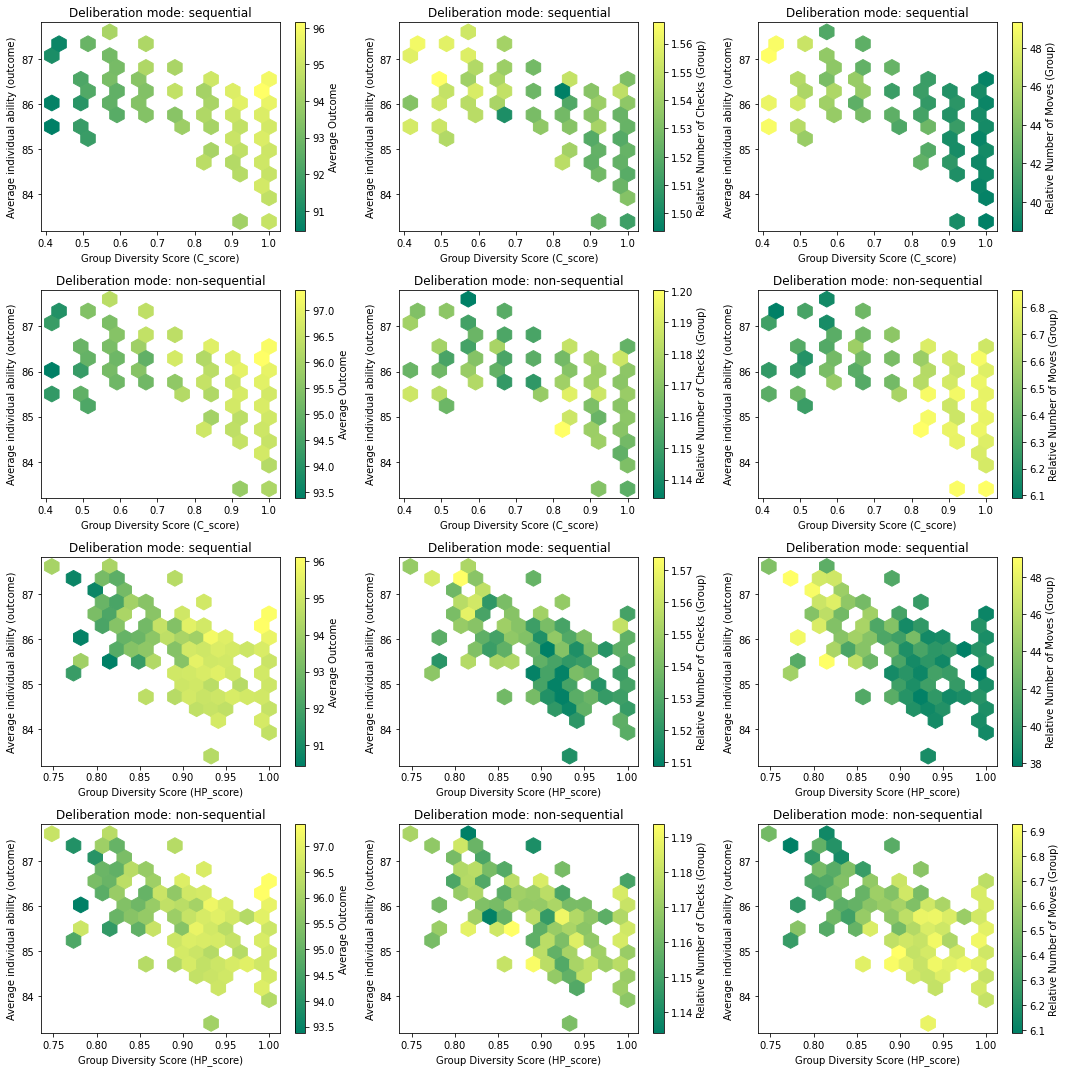

In [41]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_12_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_12_complete.csv'

get_results_ab_div(path1, path2, relative_eff=True)

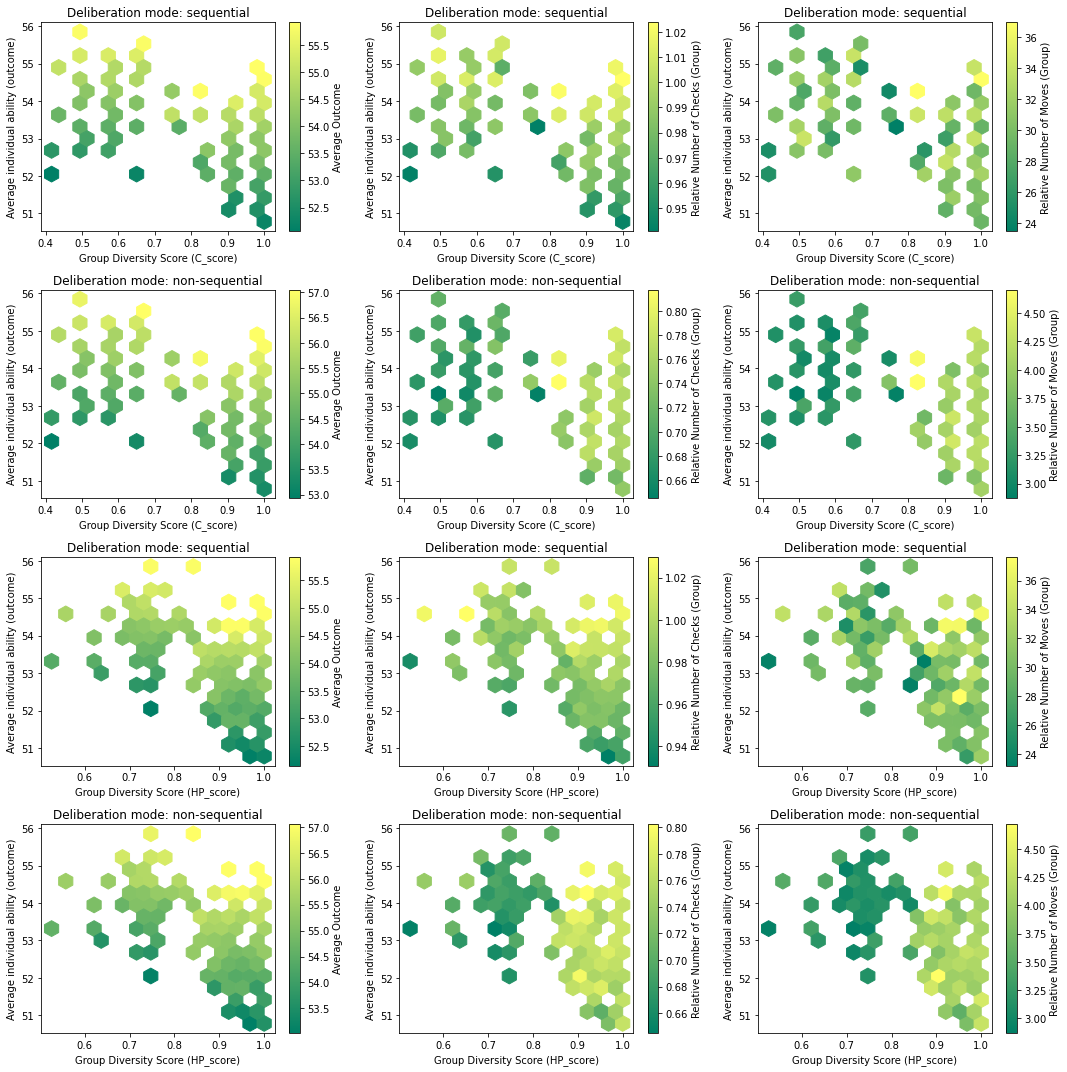

In [42]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_12_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_12_complete.csv'

get_results_ab_div(path1, path2, relative_eff=True, correlated=True)

## Experiments 20

### Regression 

#### Uncorrelated val func 

In [239]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'

get_results_regr(path1, path2, relative_eff=False, correlated=False, assumption=False, destination=dest, output=None)

outcome
outcome
checks
checks
moves
moves


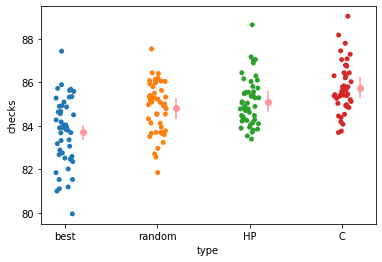

In [ ]:
import seaborn as sns


model = models['checks, non-sequential']

fig, ax = plt.subplots()
sns.stripplot(data=df_performances,x = df_performances['type'][df_performances['type']!='best_corr'],y = df_performances['checks'][df_performances['type']!='best_corr'],ax=ax, order=['best', 'random', 'HP', 'C'])
ncat = len(model.params[1:])
ax.scatter(x = np.arange(1)+0.2,y = model.params[0] , color = "#FE9898")
ax.scatter(x = np.arange(ncat)+1.2,y = model.params[1:]+model.params[0] , color = "#FE9898")
ax.vlines(x = np.arange(ncat)+1.2,
          ymin = model.conf_int().iloc[1:,0]+model.params[0],
          ymax = model.conf_int().iloc[1:,1]+model.params[0],
         color = "#FE9898")
ax.vlines(x = np.arange(1)+0.2,
          ymin = model.conf_int().iloc[0,0],
          ymax = model.conf_int().iloc[0,1],
         color = "#FE9898")

In [14]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'

get_results_regr(path1, path2, relative_eff=True, correlated=False, assumption=False, destination=dest, output='tex')

outcome
outcome
checks
checks
moves
moves


#### Correlated val func 

In [241]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'

get_results_regr(path1, path2, relative_eff=False, correlated=True, assumption=False, destination=dest, output=None)

outcome_corr
outcome_corr
checks_corr
checks_corr
moves_corr
moves_corr


In [16]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'

get_results_regr(path1, path2, relative_eff=True, correlated=True, assumption=False, destination=dest, output='tex')

outcome_corr
outcome_corr
checks_corr
checks_corr
moves_corr
moves_corr


### Correlation 

#### uncorr val func

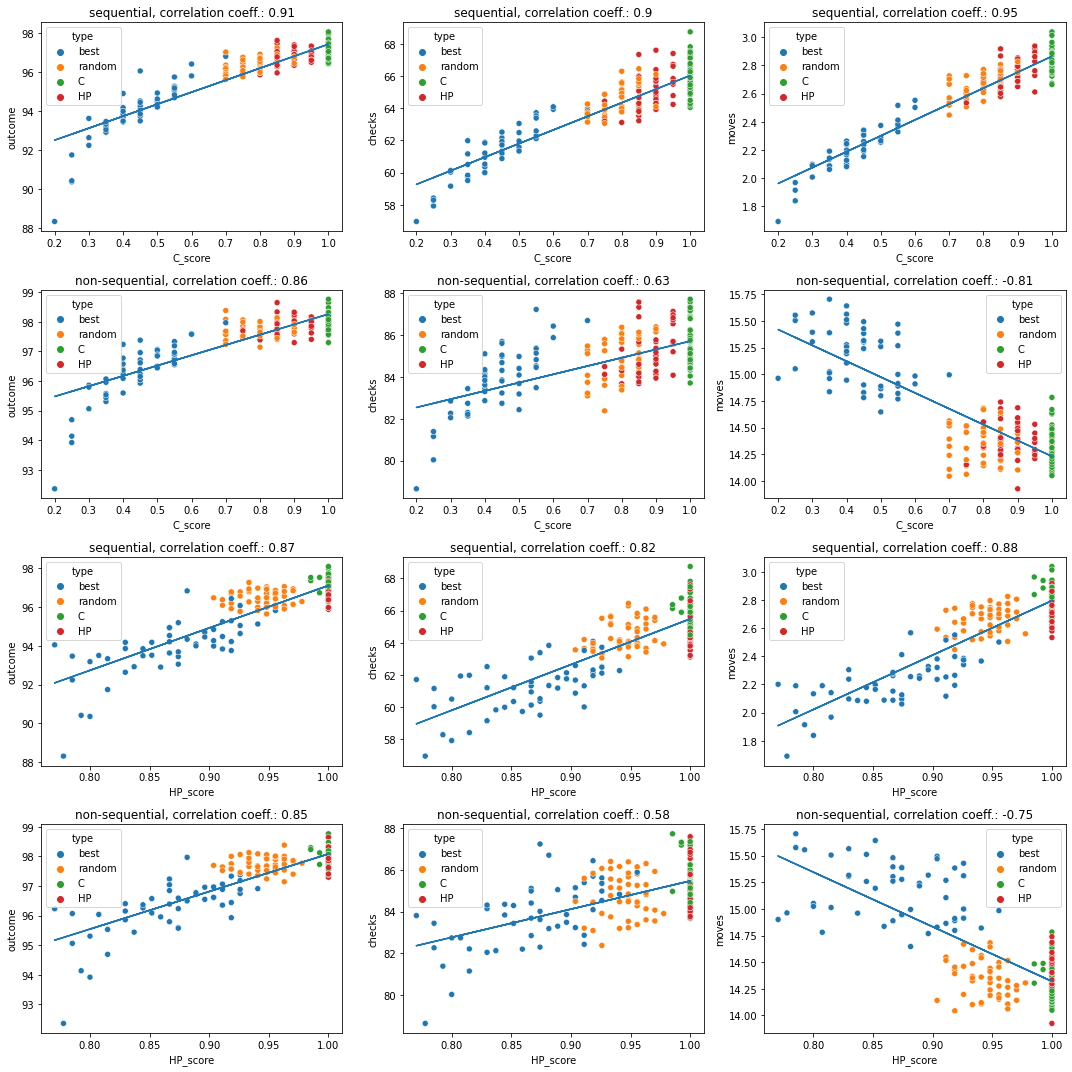

In [262]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'
dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=False, correlated=False, output=None, destination=dest)

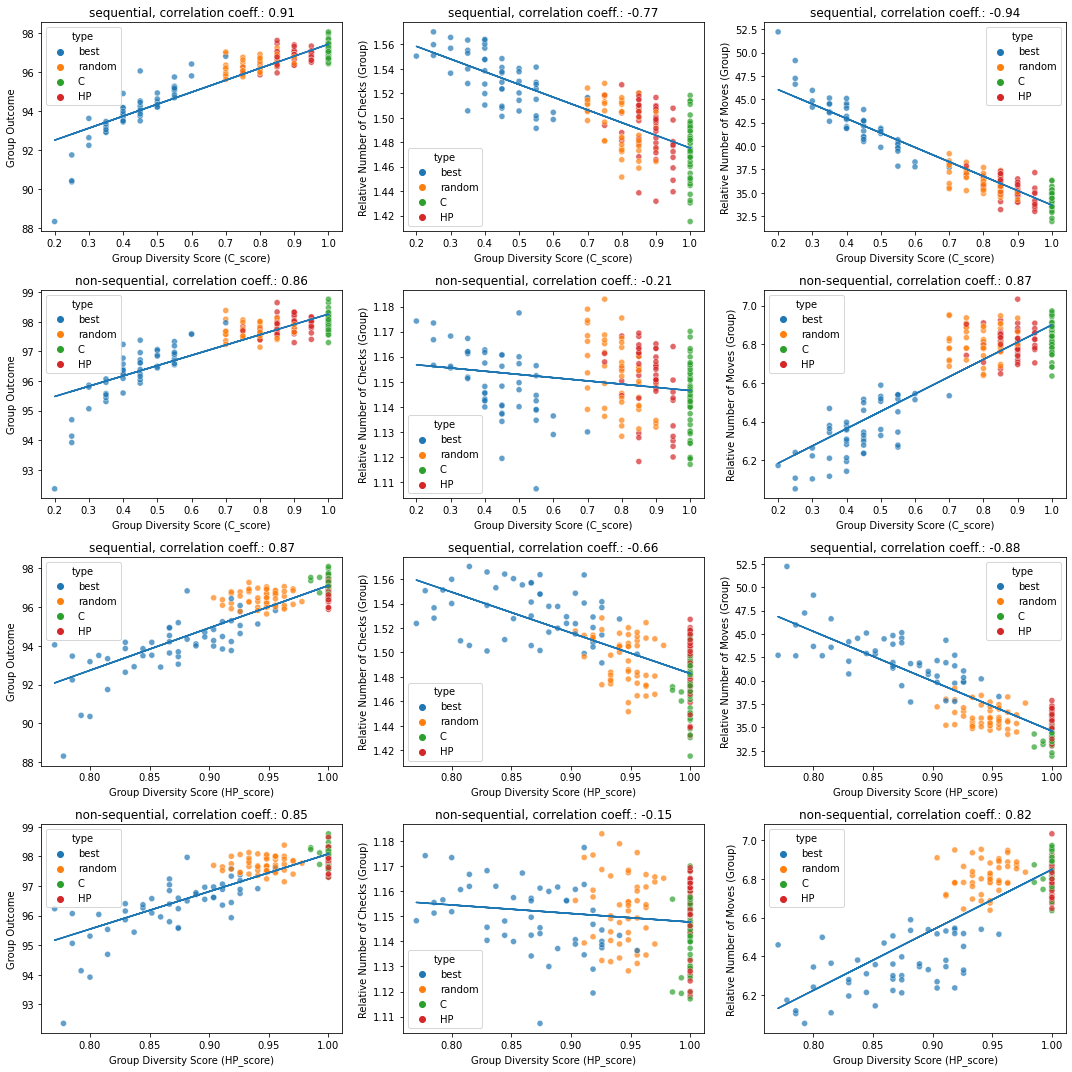

In [43]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'
dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=True, correlated=False, output=None, destination=dest)

#### correlated val func

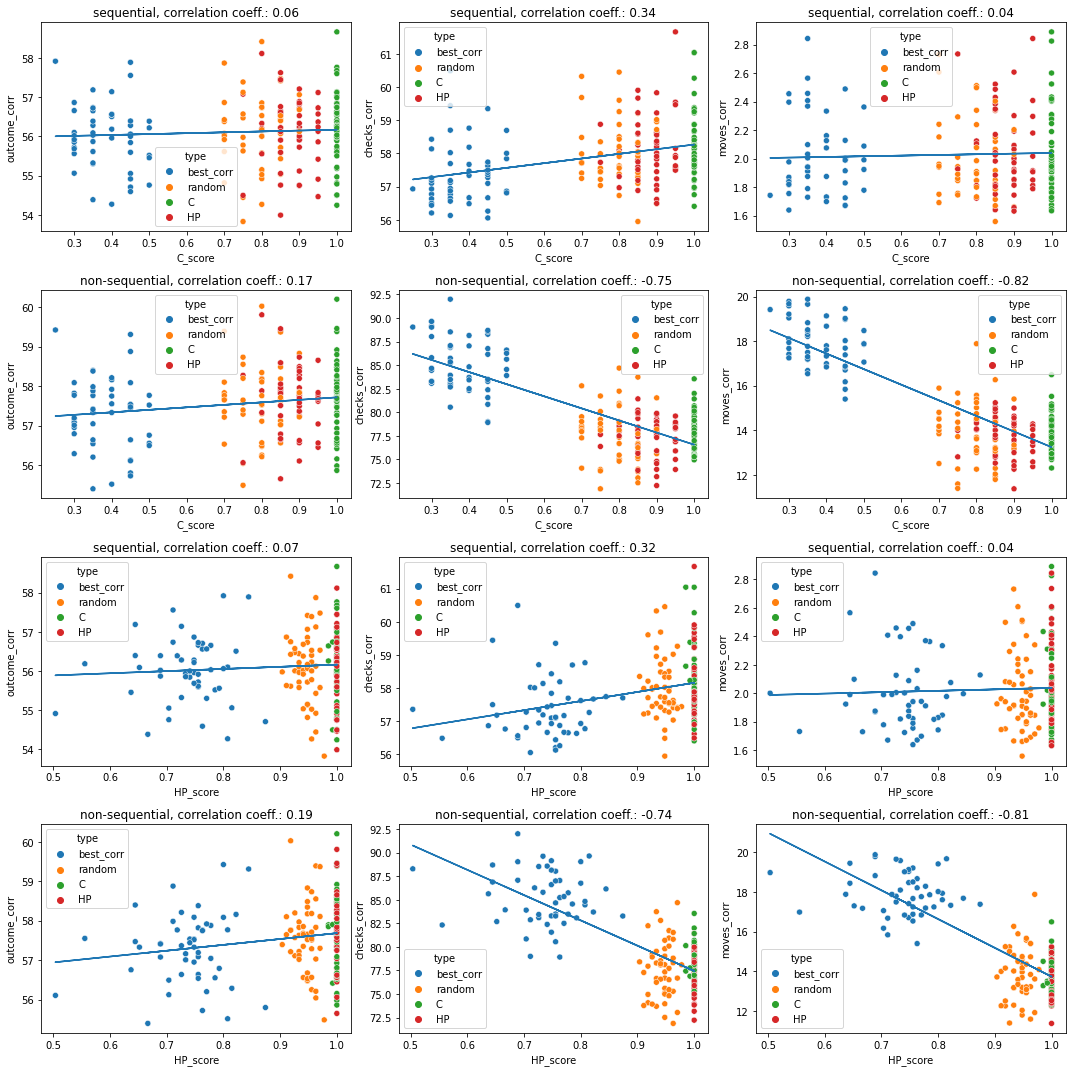

In [264]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'
dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=False, correlated=True, output=None, destination=dest)

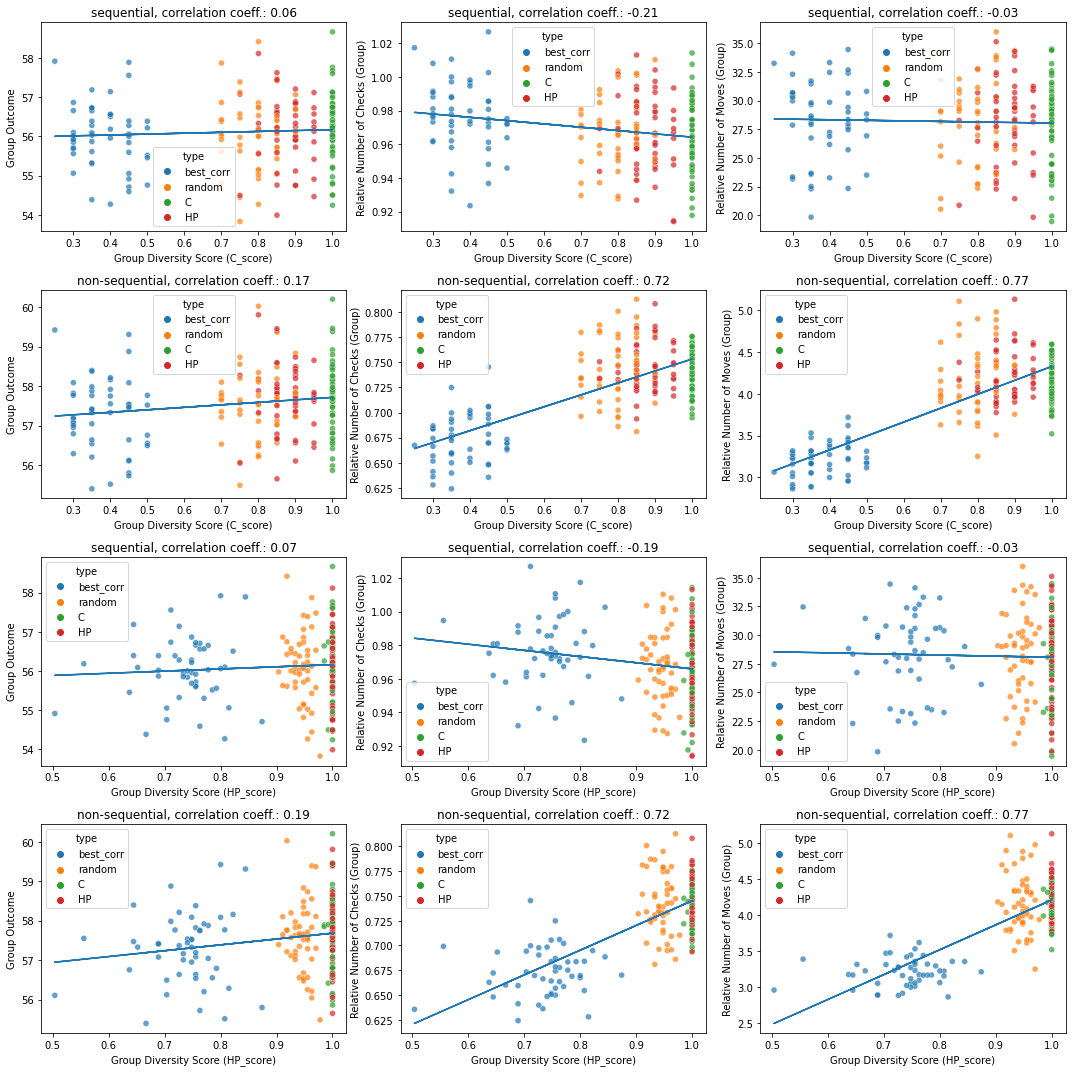

In [44]:
path1 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_seq_20.csv'
path2 = '/content/drive/My Drive/Capstone - Diversity trumps ability/Results/df_performances_20.csv'

path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_seq_new_20.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_performances_new_20.csv'
dest = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\corr_tables'

get_results_corr(path1, path2, relative_eff=True, correlated=True, output=None, destination=dest)

### Ability

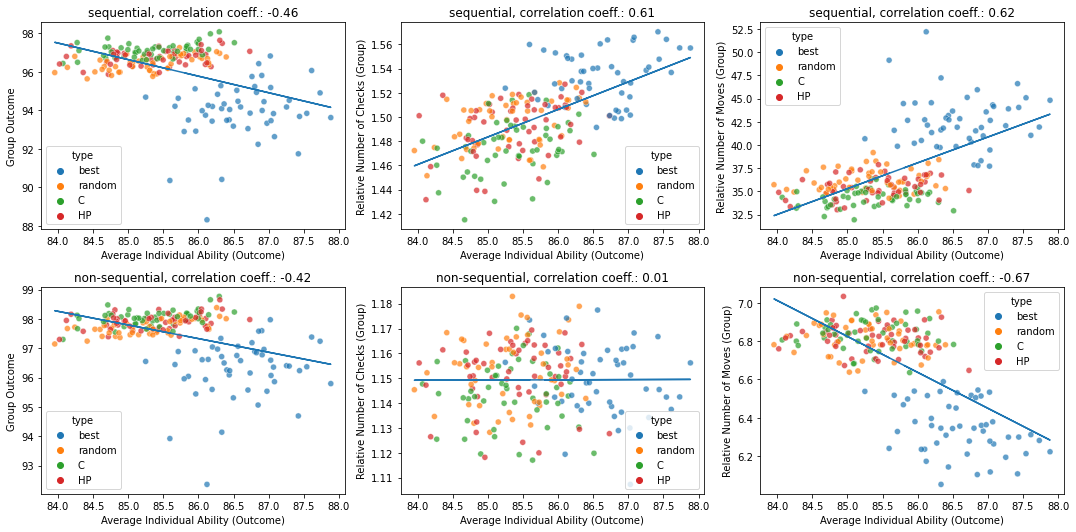

In [45]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_20_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_20_complete.csv'

get_results_corr_ab(path1, path2, relative_eff=True)

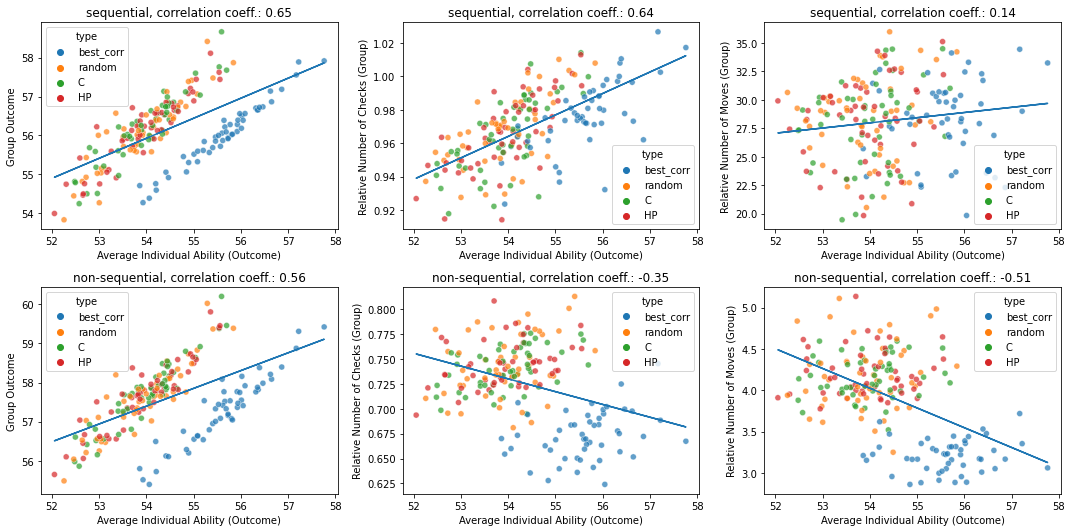

In [46]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_20_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_20_complete.csv'

get_results_corr_ab(path1, path2, relative_eff=True, correlated=True)

### Ability & Diversity 

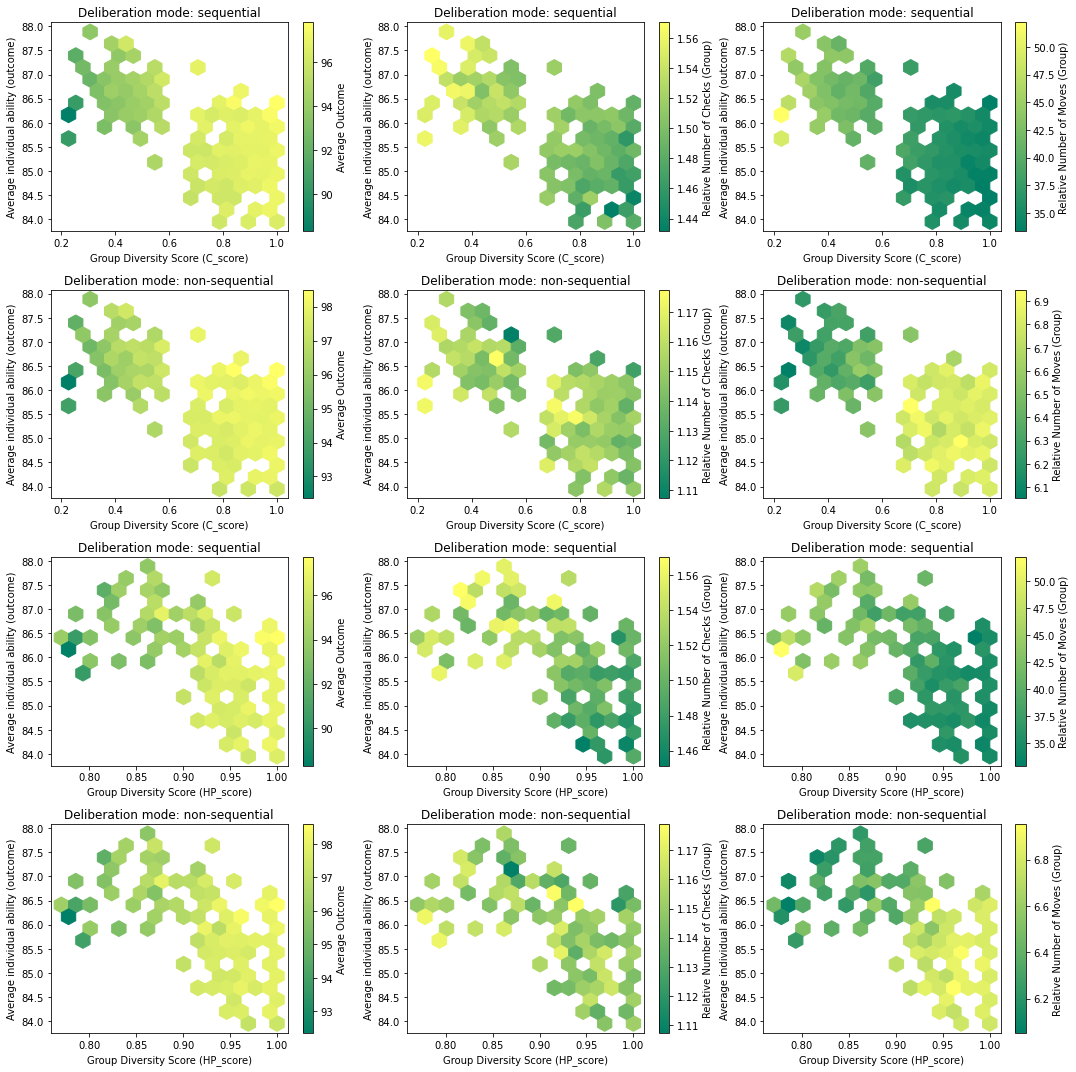

In [47]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_20_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_20_complete.csv'

get_results_ab_div(path1, path2, relative_eff=True)

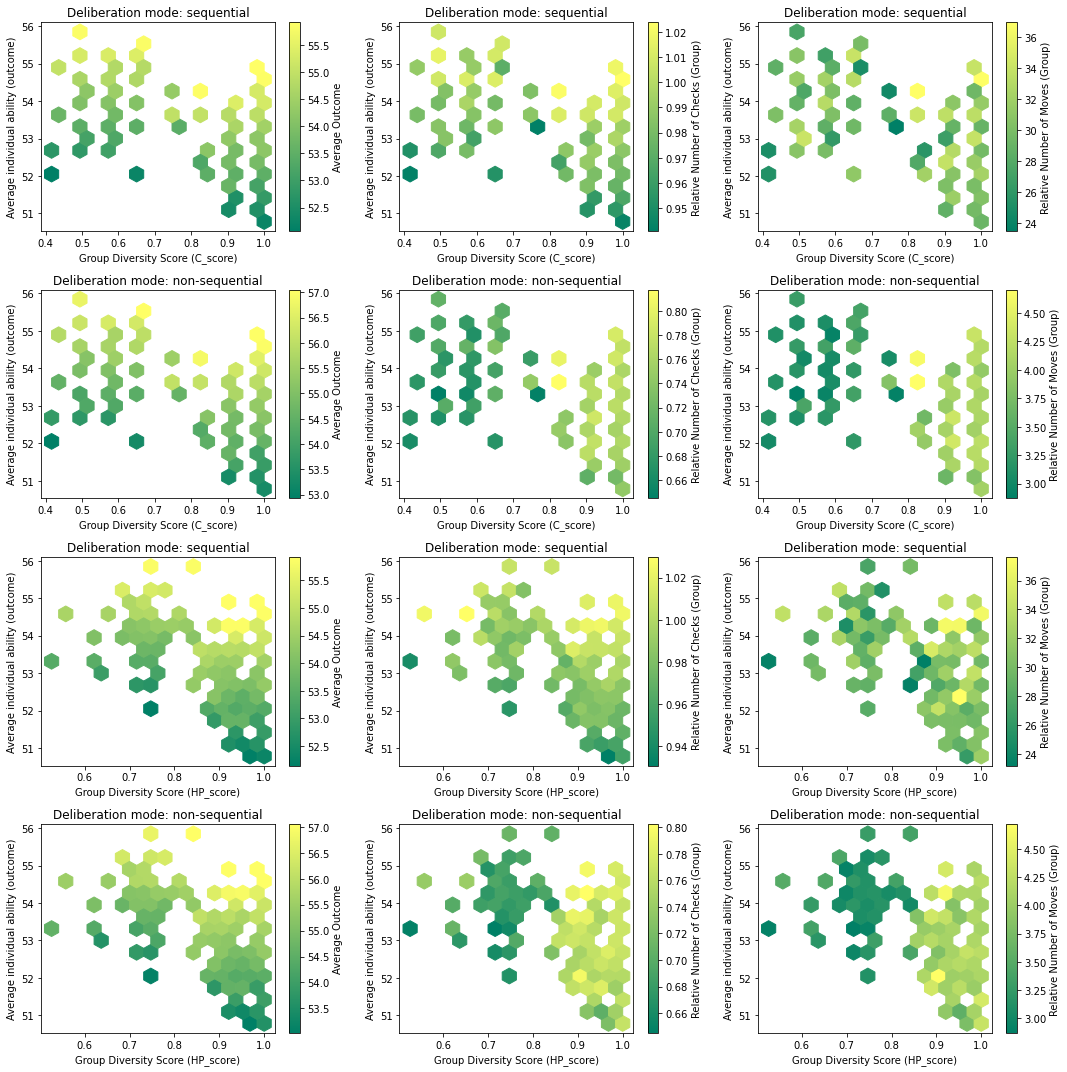

In [48]:
path1 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_seq_12_complete.csv'
path2 = r'C:\Users\Tabio\Desktop\uni\Capstone\Resources and articles\df_12_complete.csv'

get_results_ab_div(path1, path2, relative_eff=True, correlated=True)

## Plotting value functions 

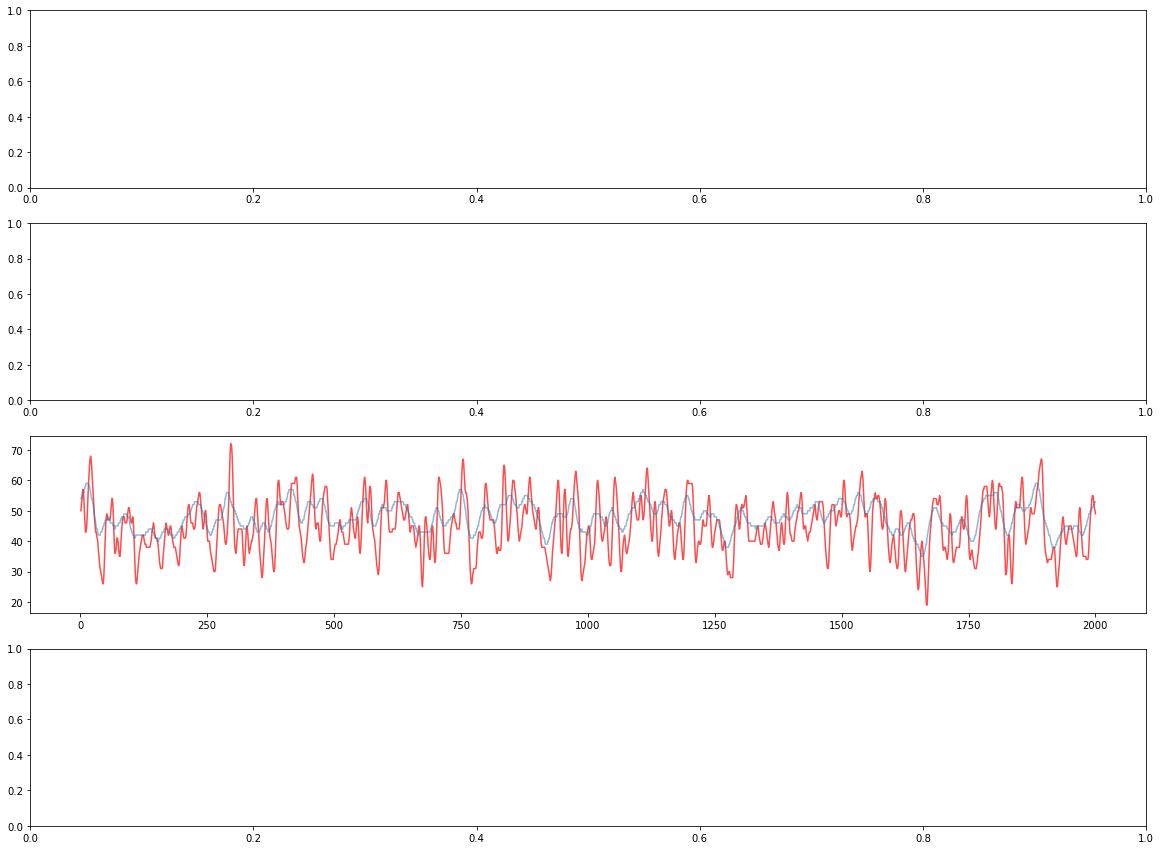

In [338]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(4,1, figsize=(20,15))

# axes[0].hist(create_value_func(correlated=True, sd=1, length=2000, seed = 42), bins=50)
# axes[1].hist(create_value_func(correlated=False, sd=1, length=2000), bins=50)
axes[2].plot(np.linspace(1,2000, 2000),create_value_func(correlated=True, window=1, runs=10, seed=41), color='red', alpha=0.7)
axes[2].plot(np.linspace(1,2000, 2000),create_value_func(correlated=True,seed=41, window=10, runs=2),alpha=0.5)
# axes[3].scatter(np.linspace(1,2000, 2000),create_value_func(correlated=False, seed=42), marker='x', alpha=0.7)
# axes[3].plot(np.linspace(1,2000, 2000),create_value_func(correlated=False, seed=42), alpha=0.5)
plt.show()

## Playground

In [ ]:
func = create_value_func(correlated=True, window=1, runs=3, length=20, seed=1)

fig, axes = plt.subplots(1,1, figsize=(5,5))
axes.bar(x=np.arange(len(func)), height=func)

agent1 = agent(heuristic_list=[1,2,11])
agent2 = agent(heuristic_list=[5,7,12])

# print(group_performance((agent1, agent1), value_func=func, sequential = True))
print()
# print('best')
group_performance((agent1, agent2), value_func=func, sequential = False)==group_performance((agent1, agent1), value_func=func, sequential = True)


In [ ]:
agent1 = agent()
agent2 = agent()

print(agent1, agent2)

C_diversity([agent1, agent2], 12, adjusted=True)

Agent 457: [10  1  5] Agent 457: [12  9  3]


1.0

In [ ]:
agent1.performance(value_func=create_value_func())


84.7195

In [ ]:
from sklearn.metrics import rand_score, adjusted_rand_score
# idea: comparing randomness (entropy) and similarity/dissimilarity 

print(rand_score((1,2,3), (3,2,1)))
print(rand_score((1,2,3), (1,3,2))) # not optimal, perhaps should consider only cases like:
print(rand_score((1,2,3), (3,1,2))) # as the same, they could be considered the same if there was an intelligent use of cognitive resources, not just trial and error --> selecting the best of the three numbers/ of all available number in a group 
# check whether it is actually the same 
# check whether different distributions 

1.0
1.0
1.0


## non-hp functions  

In [ ]:
def apply_heur(self, value_func, starting_index, heuristic_index=0, not_moved=[]): 
        """ 
        THIS ONE STARTS WITH FIRST INDEX AGAIN --> CHANGES OUTCOME FOR SEQUENTIAL VS BEST SEARCH AMONG ALL HEURISTICS AS ONE BIG AGENT
        Class method 'apply_heur' for 'walking circle'/
        applying the set of heuristics to a given value_func until local optimum is reached by checking each heuristic one after another.
        Returns optimal value and corresping index in value_func. 
        """
        current_value = value_func[starting_index]

        if sum(not_moved) >= len(self.heuristics):
            
            return current_value, starting_index

        if heuristic_index == len(self.heuristics):
            heuristic_index -= len(self.heuristics)

        current_heur = self.heuristics[heuristic_index]

        current_index = starting_index + current_heur
        
        if current_index >= len(value_func)-1:
            current_index -= len(value_func)
            
        if current_value < value_func[current_index]:
            
            starting_index = current_index
            current_value = value_func[current_index]
            not_moved = []
            heuristic_index=0
        else: 
            not_moved.append(True)

            heuristic_index += 1 # this one should only happen if not moved otherwise it should be set to 0 again - changed it for now but literature says it always goes to the next heursitic no matter what  

        return self.apply_heur(value_func, starting_index, heuristic_index, not_moved)


def group_performance(group, value_func, sequential=True): 
    """
    Takes a list of agents and a value function and returns average performance over all possible starting points 
    Sequential takes all agents as they are and uses them as one big agent - application of heurisitcs the same as with one agent
    Otherwise best in among all heuristics is chosen and applied (it is the same outcome if HP heuristic application as used)
    """
    
    # check if really best is chosen or if only best at one position is chosen 
    super_heur = np.concatenate([agent.heuristics for agent in group])

    if sequential: 
        super_agent = agent(heuristic_list=super_heur)

        return  super_agent.performance(value_func)

    else: 
        sum = 0
        improved_count = 0
        for i in range(len(value_func)): 
            current_index = i 
            sum += group_performance_helper(current_index, value_func[current_index], super_heur, value_func)
        return sum/len(value_func)



def group_performance_helper(index, current_val, super_heur, value_func): 
    improved=False
    
    
    for h in super_heur: 
        if index + h > len(value_func)-1:
            index-=len(value_func)
        # print('check_index', index+h)
        if value_func[index+h] > current_val:
            current_val = value_func[index+h]
            index += h 
            improved=True

    if improved:
        # print("step_index: ", index, current_val)
        improved=False
        return group_performance_helper(index, current_val, super_heur, value_func)
    else:
        # print(current_val)
        return current_val

# agent3 = agent()
# agent4 = agent()
# agent5 = agent()
# agent6 = agent()
# agent7 = agent()
# agent8 = agent()

# func = create_value_func(correlated=True, window=10, runs=3)


# print(agent1, agent2)

# print(group_performance((agent1, agent2), value_func=func, sequential = False) == group_performance((agent1, agent2), value_func=func, sequential = True))
# print('SEQ')


    